# Section 1: Introduction to the Problem, Task, and Dataset

## 1.1 Dataset Summary

The Synthea Lung Cancer Synthetic Patient Dataset is a synthetic healthcare dataset designed for machine learning research in lung cancer risk prediction. Created using the Synthea platform, it simulates realistic, anonymous electronic health records (EHRs). The dataset consists of cumulative cohorts, scaling from 30,000 to 150,000 patients, with a controlled 3:1 ratio of control-to-case patients. Clinical features are coded using standardized nomenclatures like SNOMED-CT and LOINC. This dataset is ideal for developing and benchmarking predictive models in a privacy-preserving environment. It was notably used in the Nature Scientific Reports paper, "Simulation of a machine learning enabled learning health system for risk prediction using synthetic patient data," which serves as a benchmark for this project.

## 1.2 Problem We're Trying to Solve

The primary problem is the early and accurate detection of lung cancer. As a leading cause of cancer-related mortality, its high fatality rate is often due to diagnosis at advanced stages. Early detection significantly improves survival rates. This project aims to build a machine learning model that can analyze a patient's medical data (diagnoses, lab results, history) to predict their risk of having lung cancer. The ultimate goal is to create a model that could be integrated into a clinical decision support system, helping clinicians identify high-risk individuals for targeted screening, such as CT scans, before symptoms become apparent.

## 1.3 Why This Dataset is Useful

The Synthea dataset is exceptionally useful for this task because:
1.  **Machine-Learning-Ready:** It is structured for a classification task with a defined binary target (`label`) and a controlled class ratio.
2.  **Longitudinal Data:** It captures a patient's medical history over time, which is crucial for identifying long-term risk factors.
3.  **Reproducibility & Accessibility:** Being synthetic, it bypasses the privacy and ethical constraints of real EHR data, allowing for fully reproducible research.
4.  **Academic Validation:** Its use in a peer-reviewed Nature paper validates its quality and provides a direct performance benchmark for our models.

## 1.4 Identify if Classification or Regression

This is a **binary classification** problem. The goal is to classify each patient instance into one of two categories: `1` (has lung cancer) or `0` (does not have lung cancer), based on over 700 medical features.

## 1.5 Machine Learning Model's Goal

Our goal is to build, evaluate, and compare several supervised classification models to predict the presence of lung cancer. We will implement four distinct models:
- **Logistic Regression:** A simple, interpretable linear model to serve as a strong baseline.
- **Support Vector Machine (SVM):** A powerful kernel-based model effective in high-dimensional spaces.
- **XGBoost Classifier:** A state-of-the-art gradient boosting model, which the original research paper found to be the most effective.

Our group's objective is to replicate the findings of the benchmark paper, tune the best models for optimal performance, and produce a robust model for lung cancer risk prediction.

# Section 2: Description of the Dataset

## 2.1 Summary & 2.2 Dataset Origin

This dataset was synthetically generated using the MITRE Corporation's open-source Synthea™ platform. It models the health histories of 150,000 patients, from which lung cancer cases and a control group were extracted to create machine-learning-ready tables. The data is publicly available on Harvard Dataverse, ensuring accessibility and traceability.

## 2.3 Purpose of the Dataset

The dataset was created to facilitate the development and validation of machine learning models for lung cancer risk prediction in a simulated "learning health system." It provides a safe, privacy-preserving alternative to real patient data for training and benchmarking predictive algorithms.

## 2.4-2.8 Data Collection, Structure, and Files

The data was generated algorithmically based on public health statistics and clinical guidelines. All medical events are coded with SNOMED-CT and LOINC standards. The raw dataset contains over 700 columns, including ptnum (a patient identifier), scc (Squamous Cell Carcinoma Antigen), and hundreds of feature columns. However, for the purpose of this predictive model, both ptnum and scc were deliberately excluded from the feature set. ptnum was removed as it is a non-predictive identifier, and scc was removed to prevent severe target leakage, as it is a biomarker typically measured only after a suspicion of cancer already exists, making it unsuitable for an early-detection model.

The feature selection process was entirely data-driven to avoid premature assumptions about feature relevance. Instead of manual exclusion, we implemented a robust, three-stage programmatic approach. This involved first ranking all features using a Random Forest model, then using 5-fold cross-validation to empirically determine that the optimal number of features was 60. Finally, this set was further refined by removing highly correlated features, resulting in a final, powerful set of 52 predictors. This method ensures that the final model is built only on the most informative and non-redundant features available.

## 2.9 Features That Are Not Used

Initially, we will use a programmatic approach to feature selection rather than manually excluding features. Many features may seem unrelated (e.g., `C-65363002`: otitis media), but an algorithm might find subtle correlations. We will use a Random Forest model to rank all features by their predictive importance and select the top 150. This is a more robust and data-driven method than manual selection and helps prevent the "Curse of Dimensionality."

# Section 3: List of Requirements (Python Libraries)

## 3.1 Python Libraries Used

This project relies on the following Python libraries for data analysis, preprocessing, modeling, and visualization.

-   **pandas:** For data loading, manipulation, and preprocessing. Version: 2.x
-   **numpy:** For numerical computations and array handling. Version: 1.2x
-   **matplotlib:** For creating static, animated, and interactive visualizations. Version: 3.x
-   **seaborn:** For high-level statistical data visualization. Version: 0.12.x
-   **scikit-learn:** For core machine learning tasks, including:
    -   Model training (Logistic Regression, Decision Tree, SVM, Random Forest)
    -   Data splitting (`train_test_split`)
    -   Model evaluation (metrics like accuracy, precision, recall, F1-score)
    -   Hyperparameter tuning (`GridSearchCV`)
    -   Version: 1.x
-   **xgboost:** For implementing the XGBoost Classifier model. Version: 1.7.x

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob # To find all the data files

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Section 4: Data Preprocessing and Cleaning

### **Preprocessing**

Our approach for this section is significantly streamlined by leveraging the pre-processed `synthea-pt60k-lc-data-sel-convert.tab` dataset provided by the original authors. This decision is based on a careful analysis of the benchmark paper by Chen et al. (2022).

**Justification:**
1.  **Performance Plateau:** The paper's results (Table 1 and Figure 4) show that model performance for lung cancer prediction reaches a near-optimal point with the 60k patient dataset. Increasing the dataset to 120k or 150k patients yields only marginal gains at a significantly higher computational cost.
2.  **Efficiency and Focus:** Using this pre-processed file allows us to bypass the highly complex and time-consuming steps of consolidating 150k raw records, performing extensive one-hot encoding, and initial feature selection. This allows us to focus our efforts on the core machine learning tasks: model training, hyperparameter tuning, and in-depth error analysis, which are more critical for this project.

Our steps in this section are therefore focused on **loading, verifying, and preparing** this high-quality, pre-processed data.

### **4.1 Data Loading and Header Assignment [TO BE CHANGED]**


Our approach is to first load the clean column names from `synthea-lc-dataset-codes.csv`. Then, we load the main data file, telling Pandas that the first row is the header, and immediately replace those headers with the clean, consistent names from the codes file. This ensures the data is parsed into its proper (8484, 791) tabular structure.

In [ ]:
# Define filenames
codes_filename = 'synthea-lc-dataset-codes.csv'
data_filename = 'synthea-pt60k-lc-data-sel-convert.csv'

try:
    # Step 1: Load the codes file to create a mapping dictionary
    codes_df = pd.read_csv(codes_filename)

    # Create a mapping dictionary from code to name
    code_to_name = dict(zip(codes_df['code'], codes_df['name']))
    print(f"Loaded {len(code_to_name)} code mappings from '{codes_filename}'.")

    # Display a few examples of the mapping
    print("\nExample mappings:")
    for i, (code, name) in enumerate(list(code_to_name.items())[:5]):
        print(f"  {code} -> {name}")

    # Step 2: Load the main data file
    df = pd.read_csv(data_filename, header=0, low_memory=False)
    print(f"\nOriginal dataset shape: {df.shape}")
    print(f"Original column names (first 5): {list(df.columns[:5])}")

    # Step 3: Replace column names using the mapping
    # For columns that have matching codes, replace with names
    # For columns that don't match, keep original names
    new_column_names = []
    for col in df.columns:
        if col in code_to_name:
            new_column_names.append(code_to_name[col])
            print(f"Replaced: {col} -> {code_to_name[col]}")
        else:
            new_column_names.append(col)
            print(f"Kept original: {col}")

    # Apply the new column names
    df.columns = new_column_names

    print(f"\nSuccessfully processed '{data_filename}' with mapped headers.")
    print(f"Dataset Shape: {df.shape}")
    print(f"New column names (first 10): {list(df.columns[:10])}")

    # Display the first few rows
    display(df.head())

    # Optional: Save the processed dataset
    output_filename = 'synthea-pt60k-lc-data-with-names.csv'
    df.to_csv(output_filename, index=False)
    print(f"\nProcessed dataset saved as: {output_filename}")

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
    df = None
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

Loaded 791 code mappings from 'synthea-lc-dataset-codes.csv'.

Example mappings:
  C-103579009 -> race
  C-125680007 -> marital
  C-186034007 -> ethnic
  C-263495000 -> gender
  C-398070004 -> state

Original dataset shape: (8484, 774)
Original column names (first 5): ['ptnum', 'label', 'scc', 'C-103579009', 'C-125680007']
Kept original: ptnum
Kept original: label
Kept original: scc
Replaced: C-103579009 -> race
Replaced: C-125680007 -> marital
Replaced: C-186034007 -> ethnic
Replaced: C-263495000 -> gender
Replaced: C-398070004 -> state
Replaced: C-424144002 -> age
Replaced: C-72514-3 -> Pain severity - 0-10 verbal numeric rating [Score] - Reported
Replaced: C-140 -> Influenza  seasonal  injectable  preservative free
Replaced: C-18262-6 -> Low Density Lipoprotein Cholesterol
Replaced: C-2085-9 -> High Density Lipoprotein Cholesterol
Replaced: C-2093-3 -> Total Cholesterol
Replaced: C-2571-8 -> Triglycerides
Replaced: C-39156-5 -> Body Mass Index
Replaced: C-710824005 -> Assessment of 

ptnum  label  scc   race marital       ethnic gender          state  \
0    p15865      1  150  white       m  nonhispanic      m  massachusetts   
1    p27452      1  145  white       m  nonhispanic      m  massachusetts   
2   p1377.1      1  135  asian       s  nonhispanic      m  massachusetts   
3    p12382      1  133  white       m  nonhispanic      m  massachusetts   
4  p14786.1      1  132  white       m  nonhispanic      m  massachusetts   

     age Pain severity - 0-10 verbal numeric rating [Score] - Reported  ...  \
0   gt70                                           abnormal             ...   
1   gt70                                             normal             ...   
2  50t70                                           abnormal             ...   
3   gt70                                           abnormal             ...   
4  50t70                                           abnormal             ...   

  Influenza virus B RNA [Presence] in Respiratory specimen by NAA with probe detection  \
0                                                NaN                                     
1                                                NaN                                     
2                                                NaN                                     
3                                                NaN                                     
4                                                NaN                                     

  Influenza virus A RNA [Presence] in Respiratory specimen by NAA with probe detection  \
0                                                NaN                                     
1                                                NaN                                     
2                                                NaN                                     
3                                                NaN                                     
4                                                NaN                                     

  Adenovirus A+B+C+D+E DNA [Presence] in Respiratory specimen by NAA with probe detection  \
0                                                NaN                                        
1                                                NaN                                        
2                                                NaN                                        
3                                                NaN                                        
4                                                NaN                                        

  SARS-CoV-2 RNA Pnl Resp NAA+probe Natazia 28 Day Pack  \
0                               NaN                 NaN   
1                               NaN                 NaN   
2                               NaN                 NaN   
3                               NaN                 NaN   
4                               NaN                 NaN   

  Hydroxychloroquine Sulfate 200 MG Oral Tablet  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  1 ML denosumab 60 MG/ML Prefilled Syringe  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

  Fexofenadine hydrochloride 60 MG Oral Tablet Leronlimab 700 MG Injection  \
0                                          NaN                         NaN   
1                                          NaN                         NaN   
2                                          NaN                         NaN   
3                                          NaN                         NaN   
4                                          NaN                         NaN   

  Lenzilumab 


Processed dataset saved as: synthea-pt60k-lc-data-with-names.csv


Now that the data is correctly loaded, we separate it into features (`X`) and the target (`y`). We then perform a thorough inspection to understand the true data types and the extent of missing values, which confirms the necessity of our full preprocessing pipeline.

### **4.2-4.3 Initial Cleaning and Verification and Full Preprocessing Pipeline**

The data preprocessing and cleaning pipeline was designed to be robust, prevent data leakage, and prepare the data for optimal performance across different model types. Our starting point was the synthea-pt60k-lc-data-sel-convert.csv file. Our entire process followed a strict protocol where the dataset was first split into training (80%) and testing (20%) sets. All subsequent preprocessing steps—including the calculation of statistics for imputation and scaling—were learned exclusively from the training data and then applied to the test data. This "split-then-preprocess" paradigm is fundamental to ensuring the integrity of the final model evaluation.

The pipeline consisted of the following sequential stages:

- Initial Setup and Data Splitting: The raw dataset's SNOMED-CT column headers were first mapped to human-readable names to improve interpretability, and any resulting duplicate column names were systematically de-duplicated. Following this, the dataset was stratified and split. The ptnum (patient ID) and scc (target leakage risk) columns were removed.

- Column Filtering: An initial filtering step was applied to reduce dimensionality. Any feature column in the training set with more than 60% missing values or with zero variance was removed from both the training and testing sets.

- Context-Aware Imputation: Missing values were handled using a tailored strategy. For columns representing binary events or conditions, NaN was imputed with 0 (False). For numerical columns, NaN was filled with the median calculated from the training data. For categorical columns, NaN was filled with a distinct 'Unknown' category.

- Encoding and Dual-Pipeline Creation: To prepare the data for machine learning, categorical features were converted to a numerical format using one-hot encoding. Crucially, two distinct pipelines were then established: for models sensitive to feature scale (SVM, Logistic Regression), the data was standardized using StandardScaler. Simultaneously, a separate, unscaled version of the data was preserved for the XGBoost model, which does not require scaling. This dual approach ensures that each algorithm receives data in its optimal format.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ==============================================================================
# PART 1: LOAD DATA AND FIX COLUMN NAMES (INCLUDING DUPLICATES)
# ==============================================================================
print("--- PART 1: Mapping Column Codes to Names ---")

try:
    # Define input filenames
    codes_filename = 'synthea-lc-dataset-codes.csv'
    data_filename = 'synthea-pt60k-lc-data-sel-convert.csv'

    # Load the codes file to create a mapping dictionary
    codes_df = pd.read_csv(codes_filename)
    code_to_name = dict(zip(codes_df['code'], codes_df['name']))
    print(f"Loaded {len(code_to_name)} code mappings from '{codes_filename}'.")

    # Load the main data file
    df = pd.read_csv(data_filename, header=0, low_memory=False)
    print(f"\nOriginal dataset shape: {df.shape}")

    # Step 1: Replace column names using the mapping
    original_columns = df.columns.tolist()
    new_column_names = [code_to_name.get(col, col) for col in original_columns]

    # --- DEFINITIVE FIX FOR DUPLICATE COLUMNS ---
    # This block renames any duplicates by appending _1, _2, etc.
    counts = {}
    final_cols = []
    for col in new_column_names:
        if col in counts:
            counts[col] += 1
            final_cols.append(f"{col}_{counts[col]}")
        else:
            counts[col] = 0
            final_cols.append(col)

    df.columns = final_cols

    # Report if duplicates were found and renamed
    duplicates_found = {k: v for k, v in counts.items() if v > 0}
    if duplicates_found:
        print(f"\n!! WARNING: Found and renamed {len(duplicates_found)} duplicate column name(s):")
        for name, count in duplicates_found.items():
            print(f"  - '{name}' appeared {count + 1} times.")
    else:
        print("\nNo duplicate column names found after mapping. Good!")

    print(f"\nSuccessfully processed '{data_filename}' with mapped and de-duplicated headers.")

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
    df = None
except Exception as e:
    print(f"An error occurred during column renaming: {e}")
    df = None


# ==============================================================================
# PART 2: SPLIT DATA FIRST, THEN RESPONSIBLE CLEANING
# ==============================================================================
if df is not None:
    print("\n" + "="*70)
    print("--- PART 2: Preparing Data for Preprocessing ---")

    # Define your target and identifier columns
    target_col = 'label'
    identifier_col = 'ptnum'

    # EXCLUDE SCC COLUMN
    exclude_cols = ['scc']

    # Check if 'scc' column exists and remove it
    if 'scc' in df.columns:
        df.drop(columns=['scc'], inplace=True)
        print(f"\nExcluded 'scc' column from the dataset.")
    else:
        print(f"\n'scc' column not found in dataset. Continuing without exclusion.")


    # Create target vector y and feature matrix X
    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col, identifier_col])

    print(f"\nFeature matrix (X) shape: {X.shape}")
    print(f"Target vector (y) shape: {y.shape}")



    # CRITICAL FIX: Split data BEFORE any preprocessing
    print("\n=== SPLITTING DATA BEFORE PREPROCESSING ===")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    # --- START OF THE LINEAR PREPROCESSING WORKFLOW ---
    print("\n=== STARTING RESPONSIBLE PREPROCESSING PIPELINE ===")
    print(f"Input feature shape: {X_train.shape}")
    print(f"Input missing values: {X_train.isna().sum().sum()}")

    # --- INITIAL MISSING VALUE ANALYSIS ---
    print("\n=== INITIAL MISSING VALUE ANALYSIS ===")
    missing_info = X_train.isnull().sum()
    missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
    if not missing_info.empty:
        print("Columns with missing values:")
        for col, count in missing_info.items():
            pct = (count / len(X_train)) * 100
            print(f"  {col}: {count} ({pct:.1f}%)")
    else:
        print("No missing values found.")

    # --- STEP 1: COLUMN REMOVAL ---
    print("\n=== STEP 1: COLUMN REMOVAL ANALYSIS ===")
    missing_threshold = 0.6

    # Identify columns to drop by high missingness (based on training set only)
    missing_pct = X_train.isnull().sum() / len(X_train)
    cols_to_drop_missing = missing_pct[missing_pct > missing_threshold].index.tolist()

    # Identify columns to drop by zero variance (based on training set only)
    cols_to_drop_variance = [col for col in X_train.columns if X_train[col].fillna(0).nunique() <= 1]

    print(f"  -> Identified for removal (>{missing_threshold:.0%} missing): {len(cols_to_drop_missing)} columns")
    print(f"  -> Identified for removal (Low/Zero Variance): {cols_to_drop_variance}")

    all_cols_to_drop = list(set(cols_to_drop_missing + cols_to_drop_variance))

    if all_cols_to_drop:
        X_train.drop(columns=all_cols_to_drop, inplace=True)
        X_test.drop(columns=all_cols_to_drop, inplace=True)

    print(f"Shape after removal: {X_train.shape}")

    # --- STEP 2: CONTEXT-AWARE IMPUTATION ---
    print("\n=== STEP 2: CONTEXT-AWARE IMPUTATION (ON SURVIVING COLUMNS) ===")
    event_keywords = ['(finding)', '(disorder)', '(procedure)', '(situation)', 'abuse', 'history']

    # Store imputation values from training set
    imputation_values = {}

    for col in X_train.columns:
        if X_train[col].isnull().any():
            if any(keyword in col.lower() for keyword in event_keywords):
                imputation_values[col] = 0
                X_train[col].fillna(0, inplace=True)
                print(f"  Filled event column '{col}' with 0 (False)")
            elif X_train[col].dtype == 'object':
                imputation_values[col] = 'Unknown'
                X_train[col].fillna('Unknown', inplace=True)
                print(f"  Filled categorical column '{col}' with 'Unknown'")
            elif pd.api.types.is_numeric_dtype(X_train[col]):
                median_val = X_train[col].median()
                imputation_values[col] = median_val
                X_train[col].fillna(median_val, inplace=True)
                print(f"  Filled numeric column '{col}' with median: {median_val:.2f}")

    # Apply same imputation to test set
    for col, value in imputation_values.items():
        if col in X_test.columns:
            X_test[col].fillna(value, inplace=True)

    print("Imputation complete.")

    # --- STEP 3: ONE-HOT ENCODING ---
    print("\n=== STEP 3: ONE-HOT ENCODING CATEGORICALS ===")
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    if categorical_cols:
        X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=float)
        X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=float)

        # Align columns between train and test sets
        train_cols = set(X_train.columns)
        test_cols = set(X_test.columns)

        # Add missing columns to test set
        for col in train_cols - test_cols:
            X_test[col] = 0

        # Remove extra columns from test set
        for col in test_cols - train_cols:
            X_test.drop(columns=[col], inplace=True)

        # Ensure same column order
        X_test = X_test[X_train.columns]

        print(f"  -> Encoded {len(categorical_cols)} categorical columns. New shape: {X_train.shape}")
    else:
        print("  -> No categorical columns to encode.")

    # --- Create a copy for tree-based models BEFORE scaling ---
    print("\n=== CREATING UNSCALED DATASET FOR TREE MODELS (XGBOOST) ===")
    X_train_for_trees = X_train.copy()
    X_test_for_trees = X_test.copy()
    print("Unscaled data copies created.")

    # --- STEP 4: SCALING ---
    print("\n=== STEP 4: SCALING NUMERIC FEATURES FOR GENERAL MODELS (SVM, LOGREG) ===")
    numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
    if numeric_features:
        scaler = StandardScaler()
        X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
        X_test[numeric_features] = scaler.transform(X_test[numeric_features])
        print(f"  -> Scaled {len(numeric_features)} columns.")

    # --- FINAL SUMMARY & SAVE ---
    print("\n=== FINAL RESULTS ===")
    print(f"Final SCALED training shape (for SVM/LogReg): {X_train.shape}")
    print(f"Final UNSCALED training shape (for XGBoost): {X_train_for_trees.shape}")
    print(f"Final SCALED test shape (for SVM/LogReg): {X_test.shape}")
    print(f"Final UNSCALED test shape (for XGBoost): {X_test_for_trees.shape}")
    print(f"Missing values after processing (scaled train): {X_train.isna().sum().sum()}")
    print(f"Missing values after processing (scaled test): {X_test.isna().sum().sum()}")
    print(f"Missing values after processing (unscaled train): {X_train_for_trees.isna().sum().sum()}")
    print(f"Missing values after processing (unscaled test): {X_test_for_trees.isna().sum().sum()}")

    output_filename = 'final_cleaned_model_ready_data.csv'
    xgboost_output_filename = 'xgboost_final_cleaned_model_ready_data.csv'
    try:
        X_train.to_csv(output_filename, index=False)
        print(f"\nCleaned SCALED training data successfully saved to '{output_filename}'")
        X_train_for_trees.to_csv(xgboost_output_filename, index=False)
        print(f"Cleaned UNSCALED training data successfully saved to '{xgboost_output_filename}'")
    except Exception as e:
        print(f"\nError saving file: {e}")

    print("\n--- First 5 rows of final cleaned SCALED training data: ---")
    print(X_train.head())
    print("\n--- First 5 rows of final cleaned UNSCALED training data (for XGBoost): ---")
    print(X_train_for_trees.head())

else:
    print("\nDataFrame 'df' was not loaded correctly in Part 1. Halting execution.")

--- PART 1: Mapping Column Codes to Names ---
Loaded 791 code mappings from 'synthea-lc-dataset-codes.csv'.

Original dataset shape: (8484, 774)

!! WARNING: Found and renamed 5 duplicate column name(s):
  - 'Carbon Dioxide' appeared 2 times.
  - 'Sodium' appeared 2 times.
  - 'Creatinine' appeared 2 times.
  - 'Potassium' appeared 2 times.
  - 'Estrogen+Progesterone receptor Ag [Presence] in Tissue by Immune stain' appeared 2 times.

Successfully processed 'synthea-pt60k-lc-data-sel-convert.csv' with mapped and de-duplicated headers.

--- PART 2: Preparing Data for Preprocessing ---

Excluded 'scc' column from the dataset.

Feature matrix (X) shape: (8484, 771)
Target vector (y) shape: (8484,)

=== SPLITTING DATA BEFORE PREPROCESSING ===
Training set shape: (6787, 771)
Test set shape: (1697, 771)

=== STARTING RESPONSIBLE PREPROCESSING PIPELINE ===
Input feature shape: (6787, 771)
Input missing values: 4543620

=== INITIAL MISSING VALUE ANALYSIS ===
Columns with missing values:
  0.67

/tmp/ipython-input-19-2576907447.py:125: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cols_to_drop_variance = [col for col in X_train.columns if X_train[col].fillna(0).nunique() <= 1]


  -> Identified for removal (>60% missing): 700 columns
  -> Identified for removal (Low/Zero Variance): ['state', 'Attempted suicide - suffocation', 'Sputum Culture', 'Oral Glucose Tolerance Test', 'Transfusion of plasma (procedure)', 'canagliflozin 100 MG Oral Tablet', 'Intravenous infusion (procedure)', 'History of upper limb amputation (situation)', 'Asthma screening', 'neratinib 40 MG Oral Tablet', 'Lupus erythematosus', 'Grass pollen (substance)', 'Intravenous antibiotic therapy', 'Bee venom (substance)', 'Body mass index 40+ - severely obese (finding)', 'Sepsis caused by Staphylococcus aureus', 'Sepsis caused by Pseudomonas (disorder)', 'Incision of trachea (procedure)', 'History of disarticulation at wrist (situation)', '0.67 ML anakinra 149 MG/ML Prefilled Syringe', 'Take blood sample']
Shape after removal: (6787, 70)

=== STEP 2: CONTEXT-AWARE IMPUTATION (ON SURVIVING COLUMNS) ===
  Filled categorical column 'Pain severity - 0-10 verbal numeric rating [Score] - Reported' with

/tmp/ipython-input-19-2576907447.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna('Unknown', inplace=True)
/tmp/ipython-input-19-2576907447.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

  -> Encoded 70 categorical columns. New shape: (6787, 105)

=== CREATING UNSCALED DATASET FOR TREE MODELS (XGBOOST) ===
Unscaled data copies created.

=== STEP 4: SCALING NUMERIC FEATURES FOR GENERAL MODELS (SVM, LOGREG) ===
  -> Scaled 105 columns.

=== FINAL RESULTS ===
Final SCALED training shape (for SVM/LogReg): (6787, 105)
Final UNSCALED training shape (for XGBoost): (6787, 105)
Final SCALED test shape (for SVM/LogReg): (1697, 105)
Final UNSCALED test shape (for XGBoost): (1697, 105)
Missing values after processing (scaled train): 0
Missing values after processing (scaled test): 0
Missing values after processing (unscaled train): 0
Missing values after processing (unscaled test): 0

Cleaned SCALED training data successfully saved to 'final_cleaned_model_ready_data.csv'
Cleaned UNSCALED training data successfully saved to 'xgboost_final_cleaned_model_ready_data.csv'

--- First 5 rows of final cleaned SCALED training data: ---
      race_black  race_hawaiian  race_native  race_oth

## 4.4 Feature Selection


With a large number of features, many of which may be redundant or irrelevant, a feature selection process is critical. It helps to:
1.  **Improve Model Performance:** By removing noise, models can often generalize better.
2.  **Reduce Overfitting:** Fewer features can lead to simpler models that are less likely to overfit the training data.
3.  **Decrease Computational Cost:** Training models on fewer features is significantly faster.

Our comprehensive process will involve three key stages:
1.  **Feature Ranking:** We will use Random Forest's feature importance to rank all features by their predictive power.
2.  **Finding Optimal Feature Count:** We will test various numbers of top features to find the optimal quantity that maximizes model performance using cross-validation.
3.  **Removing Collinearity:** We will analyze the top features for high correlation and remove redundant ones to create a final, efficient feature set.

FEATURE SELECTION ON CLEANED DATA
Cleaned training feature matrix (X_train) shape: (6787, 105)
Cleaned test feature matrix (X_test) shape: (1697, 105)
Training target vector (y_train) shape: (6787,)
Test target vector (y_test) shape: (1697,)
Missing values in X_train: 0
Missing values in X_test: 0
Training target distribution:
label
0    4993
1    1794
Name: count, dtype: int64

RUNNING FEATURE SELECTION ON CLEANED DATA

--- Starting Feature Selection on 105 features ---
Training set shape: (6787, 105)
Testing set shape: (1697, 105)

1. Ranking features using Random Forest importance...
Baseline F1-score with all features: 0.8872 ± 0.0125

Top 10 most important features identified:
                                                                         feature  importance
                                                                        age_gt70    0.135390
                                                                        gender_m    0.089763
                              

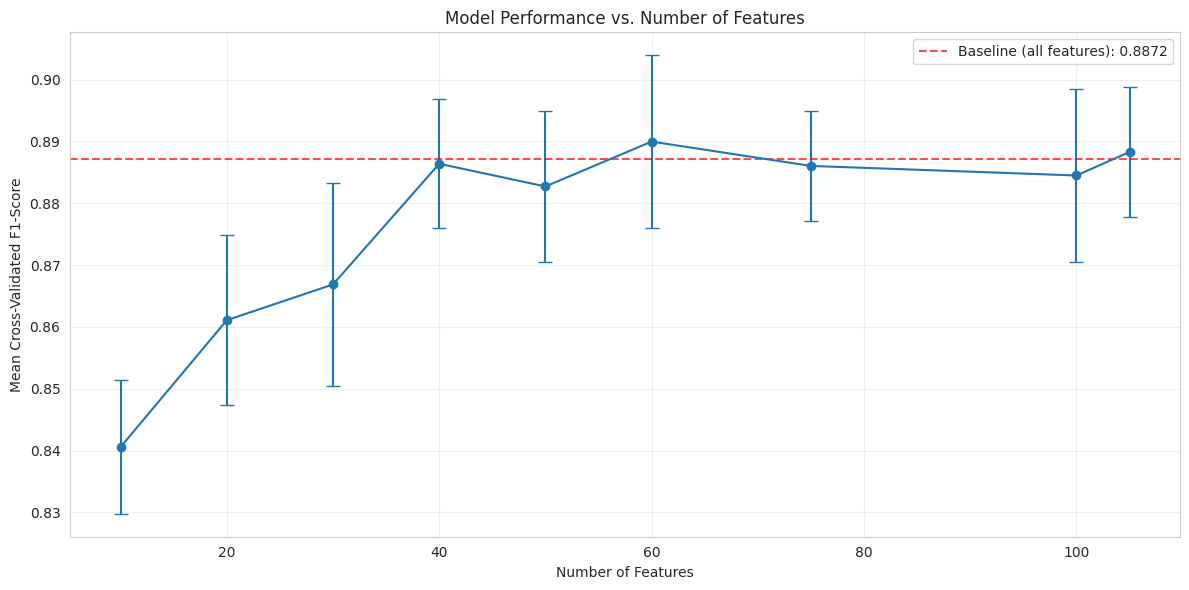


Optimal number of features found: 60
Best F1-score: 0.8900

3. Checking for high correlation among the top 60 features...
  Found and removed 8 highly correlated features (>0.95):
    - Development of individualized plan of care (procedure)_True
    - Tobacco smoking status NHIS_never
    - Hematocrit [Volume Fraction] of Blood by Automated count_abnormal
    - Low Density Lipoprotein Cholesterol_normal
    - Hospice care (regime/therapy)_Unknown
    - Certification procedure (procedure)_True
    - Pain severity - 0-10 verbal numeric rating [Score] - Reported_abnormal
    - Leukocytes [#/volume] in Blood by Automated count_abnormal

4. Final validation with 52 selected features...
Final F1-score: 0.8909 ± 0.0125
Improvement over baseline: +0.0037
Feature reduction: 105 → 52 (49.5%)

FEATURE SELECTION COMPLETE
Final training data shape: (6787, 52)
Final testing data shape: (1697, 52)
Number of selected features: 52

All 52 selected features:
 1. age_gt70
 2. gender_m
 3. age_50t70
 4. 

In [ ]:
# Modified Feature Selection Code - Using Variables from Data Cleaning Script
# This assumes the data cleaning script has already been run and variables are available

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Check if we have the cleaned data from the previous script
if 'X_train' not in locals() or 'y_train' not in locals():
    print("ERROR: Variables 'X_train', 'X_test', 'y_train', 'y_test' not found!")
    print("Please run the data cleaning script first to create these variables.")

print("="*60)
print("FEATURE SELECTION ON CLEANED DATA")
print("="*60)

# Display information about the cleaned data
print(f"Cleaned training feature matrix (X_train) shape: {X_train.shape}")
print(f"Cleaned test feature matrix (X_test) shape: {X_test.shape}")
print(f"Training target vector (y_train) shape: {y_train.shape}")
print(f"Test target vector (y_test) shape: {y_test.shape}")
print(f"Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"Missing values in X_test: {X_test.isna().sum().sum()}")
print(f"Training target distribution:")
print(y_train.value_counts().sort_index())

def select_and_evaluate_features(X_train, X_test, y_train, y_test, random_state=42, correlation_threshold=0.95):
    """
    Performs a comprehensive feature selection process and returns the final feature set and data splits.

    IMPORTANT: This function now uses ALREADY SPLIT data to prevent data leakage.

    Parameters:
    -----------
    X_train : DataFrame
        Training feature matrix (already cleaned and split)
    X_test : DataFrame
        Test feature matrix (already cleaned and split)
    y_train : Series
        Training target variable
    y_test : Series
        Test target variable
    random_state : int
        Random state for reproducibility
    correlation_threshold : float
        Threshold for removing highly correlated features (default: 0.95)
    """
    print(f"\n--- Starting Feature Selection on {X_train.shape[1]} features ---")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    # --- Stage 1: Feature Ranking using Random Forest ---
    print("\n1. Ranking features using Random Forest importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Get baseline performance for comparison
    baseline_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
    baseline_score = baseline_scores.mean()
    print(f"Baseline F1-score with all features: {baseline_score:.4f} ± {baseline_scores.std():.4f}")

    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 10 most important features identified:")
    print(importances.head(10).to_string(index=False))

    # --- Stage 2: Finding the Optimal Number of Features ---
    print("\n2. Finding optimal number of features via cross-validation...")

    # Define a range of feature counts to test - adjusted based on data size
    max_features = min(X_train.shape[1], 200)  # Cap at 200 or total features, whichever is smaller
    if max_features <= 50:
        feature_counts = [10, 20, 30, 40, max_features]
    elif max_features <= 100:
        feature_counts = [10, 20, 30, 40, 50, 60, 75, max_features]
    else:
        feature_counts = [10, 20, 30, 40, 50, 60, 75, 100, 125, 150, max_features]

    # Ensure we don't test more features than available and remove duplicates
    feature_counts = sorted(list(set([n for n in feature_counts if n <= len(X_train.columns)])))

    print(f"Testing feature counts: {feature_counts}")

    cv_scores = []
    cv_stds = []

    for n in feature_counts:
        # Select the top 'n' features
        top_n_features = importances.head(n)['feature'].tolist()
        X_train_subset = X_train[top_n_features]

        # Perform 5-fold cross-validation
        # Use a simpler model for speed during this iterative process
        temp_rf = RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1)
        scores = cross_val_score(temp_rf, X_train_subset, y_train, cv=5, scoring='f1')
        cv_scores.append(scores.mean())
        cv_stds.append(scores.std())
        print(f"  {n:3d} features: Mean F1-Score = {scores.mean():.4f} ± {scores.std():.4f}")

    # Plot the results to visualize the "elbow point"
    plt.figure(figsize=(12, 6))
    plt.errorbar(feature_counts, cv_scores, yerr=cv_stds, marker='o', linestyle='-', capsize=5)
    plt.axhline(y=baseline_score, color='r', linestyle='--', alpha=0.7,
                label=f'Baseline (all features): {baseline_score:.4f}')
    plt.title('Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Cross-Validated F1-Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Determine the optimal number of features
    optimal_n_features = feature_counts[np.argmax(cv_scores)]
    best_score = max(cv_scores)
    print(f"\nOptimal number of features found: {optimal_n_features}")
    print(f"Best F1-score: {best_score:.4f}")

    # --- Stage 3: Removing Highly Correlated Features (Collinearity) ---
    print(f"\n3. Checking for high correlation among the top {optimal_n_features} features...")
    top_features_list = importances.head(optimal_n_features)['feature'].tolist()
    X_train_top = X_train[top_features_list]

    # Create correlation matrix
    corr_matrix = X_train_top.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    if to_drop:
        print(f"  Found and removed {len(to_drop)} highly correlated features (>{correlation_threshold}):")
        for feature in to_drop:
            print(f"    - {feature}")
    else:
        print(f"  No features with correlation > {correlation_threshold} found.")

    # Create the final list of selected features
    final_feature_list = [f for f in top_features_list if f not in to_drop]

    # --- Stage 4: Final Validation ---
    print(f"\n4. Final validation with {len(final_feature_list)} selected features...")
    X_train_final = X_train[final_feature_list]

    # Use full model for final evaluation
    final_rf = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    final_scores = cross_val_score(final_rf, X_train_final, y_train, cv=5, scoring='f1')
    final_score = final_scores.mean()

    print(f"Final F1-score: {final_score:.4f} ± {final_scores.std():.4f}")
    print(f"Improvement over baseline: {final_score - baseline_score:+.4f}")
    print(f"Feature reduction: {len(X_train.columns)} → {len(final_feature_list)} ({len(final_feature_list)/len(X_train.columns)*100:.1f}%)")

    # --- Return the final feature list and the original data split ---
    return final_feature_list, (X_train, X_test, y_train, y_test)

# Apply the comprehensive feature selection using the CLEANED data
print("\n" + "="*60)
print("RUNNING FEATURE SELECTION ON CLEANED DATA")
print("="*60)

try:
    selected_features, (X_train_orig, X_test_orig, y_train_orig, y_test_orig) = select_and_evaluate_features(X_train, X_test, y_train, y_test)

    # Create the final DataFrames with only the selected features
    X_train_final = X_train_orig[selected_features]
    X_test_final = X_test_orig[selected_features]

    print("\n" + "="*60)
    print("FEATURE SELECTION COMPLETE")
    print("="*60)
    print(f"Final training data shape: {X_train_final.shape}")
    print(f"Final testing data shape: {X_test_final.shape}")
    print(f"Number of selected features: {len(selected_features)}")

    # Display final selected features
    print(f"\nAll {len(selected_features)} selected features:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")

    # Save the results for future use
    print(f"\nVariables created:")
    print(f"- selected_features: List of {len(selected_features)} feature names")
    print(f"- X_train_final: Training features ({X_train_final.shape})")
    print(f"- X_test_final: Testing features ({X_test_final.shape})")
    print(f"- y_train: Training targets ({y_train.shape})")
    print(f"- y_test: Testing targets ({y_test.shape})")

    # Optional: Save selected features to a CSV file
    try:
        selected_features_df = pd.DataFrame({'selected_features': selected_features})
        selected_features_df.to_csv('selected_features.csv', index=False)
        print(f"\nSelected features saved to 'selected_features.csv'")
    except Exception as e:
        print(f"Warning: Could not save selected features to CSV: {e}")

except Exception as e:
    print(f"Error during feature selection: {e}")
    print("Please check that the data cleaning script ran successfully and variables X_train, X_test, y_train, y_test are available.")

In [ ]:
for check in selected_features:
    print(check)
print(len(selected_features))

age_gt70
gender_m
age_50t70
Carbon Dioxide_normal
Td (adult) preservative free_Unknown
Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal
Carbon Dioxide_abnormal
Chloride_normal
Glomerular filtration rate/1.73 sq M.predicted_normal
Initial patient assessment (procedure)_True
Albumin_normal
Erythrocytes [#/volume] in Blood by Automated count_normal
Hematocrit [Volume Fraction] of Blood by Automated count_normal
Tobacco smoking status NHIS_former
MCH [Entitic mass] by Automated count_normal
Erythrocytes [#/volume] in Blood by Automated count_abnormal
Chloride_abnormal
Colonoscopy_Unknown
Bilirubin.total [Mass/volume] in Serum or Plasma_normal
Body temperature_abnormal
Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma_abnormal
Acetaminophen 325 MG Oral Tablet_Unknown
Viral sinusitis (disorder)_True
Social isolation (finding)_True
Victim of intimate partner abuse (finding)_True
Hemoglobin [Mass/volume] in Blood_normal
Hemoglobin A1c/Hemog

In [ ]:
print("\nUnique values in target 'y':")
print(y.unique())

print("\nValue counts for target 'y':")
print(y.value_counts())


Unique values in target 'y':
[1 0]

Value counts for target 'y':
label
0    6242
1    2242
Name: count, dtype: int64


This basically shows the summary of the code's count of missing values, the mean of the values (after doing one-hot encoding (converting categorical to numerical labels)), and the spread of the values from the mean.

# 5.1 Target Variable Distribution

The most important piece of EDA for a classification problem is to understand the distribution of how every instance is classified and mapped to an instance.

In [ ]:
X_train_final.shape # As a sanity check, this is our X_train_final that we will use based after cleaning and feature selecting.

(6787, 52)

In [ ]:
# Assuming X_train_final is available from the feature selection step

if 'X_train_final' in locals():
    print("--- Summary Statistics for Training Features (X_train_final) ---")
    # Display descriptive statistics for numerical columns
    display(X_train_final.describe())

    # Note: describe() primarily works on numerical columns.
    # If you had non-numerical columns remaining (which shouldn't be the case after one-hot encoding),
    # you might want to look at value counts for those.
else:
    print("ERROR: X_train_final not found. Please ensure the data preprocessing and feature selection steps were run successfully.")

--- Summary Statistics for Training Features (X_train_final) ---


age_gt70      gender_m     age_50t70  Carbon Dioxide_normal  \
count  6.787000e+03  6.787000e+03  6.787000e+03           6.787000e+03   
mean   4.711128e-18  2.093834e-17  1.193486e-16          -7.014346e-17   
std    1.000074e+00  1.000074e+00  1.000074e+00           1.000074e+00   
min   -3.162278e-01 -1.166841e+00 -1.467087e+00          -2.099516e+00   
25%   -3.162278e-01 -1.166841e+00 -1.467087e+00           4.763002e-01   
50%   -3.162278e-01  8.570151e-01  6.816226e-01           4.763002e-01   
75%   -3.162278e-01  8.570151e-01  6.816226e-01           4.763002e-01   
max    3.162278e+00  8.570151e-01  6.816226e-01           4.763002e-01   

       Td (adult) preservative free_Unknown  \
count                          6.787000e+03   
mean                           3.036060e-17   
std                            1.000074e+00   
min                           -8.326844e-01   
25%                           -8.326844e-01   
50%                           -8.326844e-01   
75%                            1.200935e+00   
max                            1.200935e+00   

       Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal  \
count                                       6.787000e+03                                  
mean                                       -1.298177e-16                                  
std                                         1.000074e+00                                  
min                                        -1.158430e+00                                  
25%                                        -1.158430e+00                                  
50%                                         8.632373e-01                                  
75%                                         8.632373e-01                                  
max                                         8.632373e-01                                  

       Carbon Dioxide_abnormal  Chloride_normal  \
count             6.787000e+03     6.787000e+03   
mean              5.548661e-17    -7.302248e-17   
std               1.000074e+00     1.000074e+00   
min              -2.597577e-01    -1.494987e+00   
25%              -2.597577e-01    -1.494987e+00   
50%              -2.597577e-01     6.689022e-01   
75%              -2.597577e-01     6.689022e-01   
max               3.849742e+00     6.689022e-01   

       Glomerular filtration rate/1.73 sq M.predicted_normal  \
count                                       6.787000e+03       
mean                                        1.675068e-17       
std                                         1.000074e+00       
min                                        -9.224054e-01       
25%                                        -9.224054e-01       
50%                                        -9.224054e-01       
75%                                         1.084122e+00       
max                                         1.084122e+00       

       Initial patient assessment (procedure)_True  ...  Creatinine_normal  \
count                                 6.787000e+03  ...       6.787000e+03   
mean                                  3.193098e-17  ...      -2.931368e-17   
std                                   1.000074e+00  ...       1.000074e+00   
min                                  -1.120855e+00  ...      -1.715036e+00   
25%                                  -1.120855e+00  ...      -1.715036e+00   
50%                                   8.921759e-01  ...       5.830783e-01   
75%                                   8.921759e-01  ...       5.830783e-01   
max                                   8.921759e-01  ...       5.830783e-01   

       Pain severity - 0-10 verbal numeric rating [Score] - Reported_normal  \
count                                       6.787000e+03                      
mean                                        8.794105e-17                      
std                                         1.000074e+00                      
min                                        -

This basically shows the summary of the code's count of missing values, the mean of the values (after doing one-hot encoding (converting categorical to numerical labels)), and the spread of the values from the mean.

## 5.2 Target Variable Distribution

The most important piece of EDA for a classification problem is to understand the distribution of the target variable. This tells us if we have a balanced or imbalanced dataset.


5.1 TARGET VARIABLE DISTRIBUTION
Distribution of the target variable ('label'):
label
0    6242
1    2242
Name: count, dtype: int64

Proportion of each class:
label
0    73.57
1    26.43
Name: proportion, dtype: float64


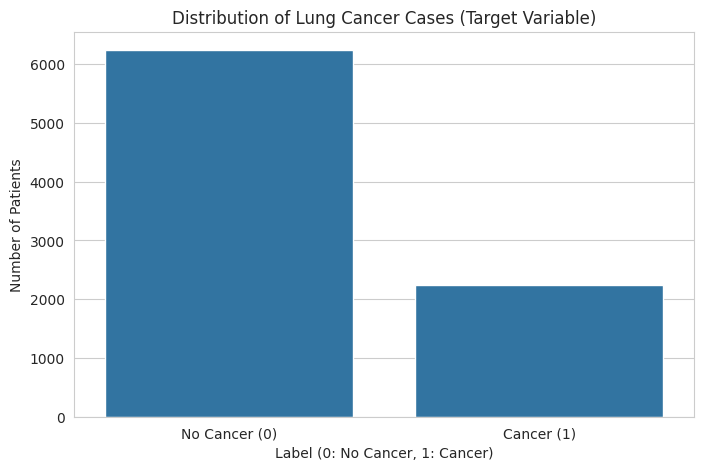


Interpretation:
The dataset is imbalanced, with approximately 26.43% cases (label 1) and 73.57% non-cases (label 0).
This imbalance needs to be considered during model training and evaluation.
Techniques like stratification, resampling, or using appropriate metrics (Precision, Recall, F1-score) will be important.


In [ ]:
# Ensure you have the target variable 'y' available from previous steps
if 'y' not in locals() or not isinstance(y, (pd.Series, np.ndarray)):
    print("ERROR: Target variable 'y' not found or is not a Series/array.")
    print("Please ensure the data loading and splitting steps were run successfully.")
else:
    print("\n" + "="*60)
    print("5.1 TARGET VARIABLE DISTRIBUTION")
    print("="*60)

    # Calculate and print the distribution
    target_counts = y.value_counts()
    target_proportions = y.value_counts(normalize=True) * 100

    print("Distribution of the target variable ('label'):")
    print(target_counts)
    print("\nProportion of each class:")
    print(target_proportions.round(2))

    # Visualize the distribution using a countplot
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title('Distribution of Lung Cancer Cases (Target Variable)')
    plt.xlabel('Label (0: No Cancer, 1: Cancer)')
    plt.ylabel('Number of Patients')
    plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'])
    plt.show()

    # Interpretation
    print("\nInterpretation:")
    if target_counts.min() / target_counts.max() < 0.5: # Example threshold for imbalance
        print(f"The dataset is imbalanced, with approximately {target_proportions.iloc[1]:.2f}% cases (label 1) and {target_proportions.iloc[0]:.2f}% non-cases (label 0).")
        print("This imbalance needs to be considered during model training and evaluation.")
        print("Techniques like stratification, resampling, or using appropriate metrics (Precision, Recall, F1-score) will be important.")
    else:
        print("The dataset appears relatively balanced.")

Based on the target-variable distribution, it can be said that the majority of distribution of patients without lung cancer is imbalanced. This means that the model may face bias as it predicts values. Some strategies to battle the imbalance bias is through stratification, resampling, or using performance metrics.

## 5.3 Visualizing the Missing Values

--- Missing Value Analysis ---
Total missing values in the dataset: 5680481

Missing values per column (showing columns with missing data):
Take blood sample                                                8484
Sepsis caused by Staphylococcus aureus                           8484
Incision of trachea (procedure)                                  8484
Sepsis caused by Pseudomonas (disorder)                          8484
History of disarticulation at wrist (situation)                  8484
                                                                 ... 
Total Cholesterol                                                   6
High Density Lipoprotein Cholesterol                                6
Low Density Lipoprotein Cholesterol                                 6
Influenza  seasonal  injectable  preservative free                  6
Pain severity - 0-10 verbal numeric rating [Score] - Reported       4
Length: 765, dtype: int64

Percentage of missing values per column:
Take blood sample     

/tmp/ipython-input-26-4106144294.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage_per_column.values, y=missing_percentage_per_column.index, palette='viridis')


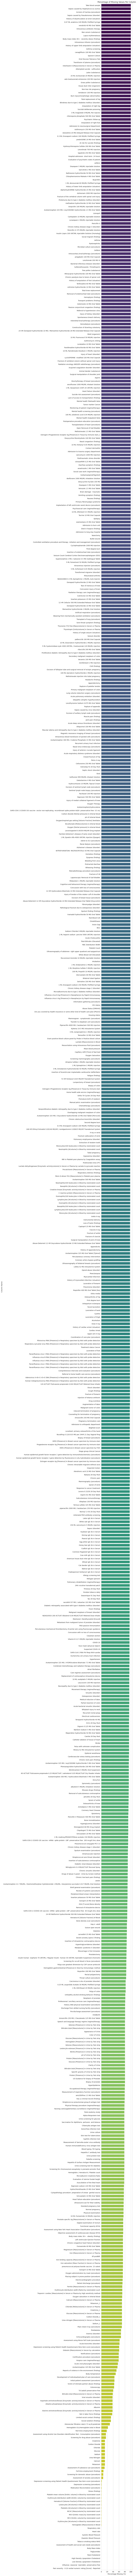

In [ ]:
# Assuming 'df' DataFrame is available from the data loading step (Section 4.1)

if 'df' in locals() and df is not None:
    print("--- Missing Value Analysis ---")

    # Calculate total missing values
    total_missing = df.isnull().sum().sum()
    print(f"Total missing values in the dataset: {total_missing}")

    # Calculate missing values per column
    missing_per_column = df.isnull().sum()

    # Filter to show only columns with at least one missing value
    missing_per_column = missing_per_column[missing_per_column > 0].sort_values(ascending=False)

    if not missing_per_column.empty:
        print("\nMissing values per column (showing columns with missing data):")
        print(missing_per_column)

        # Calculate percentage of missing values per column
        missing_percentage_per_column = (missing_per_column / len(df)) * 100

        print("\nPercentage of missing values per column:")
        print(missing_percentage_per_column.round(2))

        # --- Visualization ---
        plt.figure(figsize=(12, max(6, len(missing_per_column) * 0.3))) # Adjust figure size based on number of columns
        sns.barplot(x=missing_percentage_per_column.values, y=missing_percentage_per_column.index, palette='viridis')
        plt.title('Percentage of Missing Values Per Column')
        plt.xlabel('Percentage Missing (%)')
        plt.ylabel('Column Name')
        plt.tight_layout()
        plt.show()

    else:
        print("\nNo missing values found in the DataFrame.")

else:
    print("ERROR: DataFrame 'df' not found. Please ensure the data loading step (Section 4.1) was run successfully.")

Based from the diagram, there are 59 features whose instances have less than 50% of missing values. These features are also the highly influential ones gathered from the feature selection.

## 5.4 Univariate Analysis

Univariate analysis reveals the distribution of individual features after preprocessing. The most influential features, as identified by our feature ranking, were examined. For the binarized feature age_gt70, the analysis shows a higher count of patients who are younger than 70 years old. For gender_m, there is a relatively balanced distribution, with a slight majority of male patients. The distributions for categorical lab results, such as Carbon Dioxide_normal, show that a majority of patients fall within the "normal" range for these tests. This initial review helps confirm that the data transformations have resulted in logical, interpretable distributions ready for modeling.


--- EDA: Distribution of Top Selected Features (Univariate Analysis) ---
Analyzing distributions for the top 10 selected features:
Analyzing feature: age_gt70


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


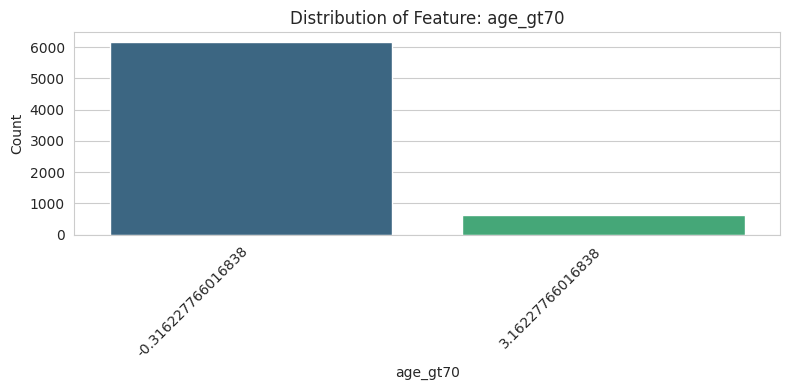

Value counts for 'age_gt70':
age_gt70
-0.316228    6170
 3.162278     617
Name: count, dtype: int64
----------------------------------------
Analyzing feature: gender_m


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


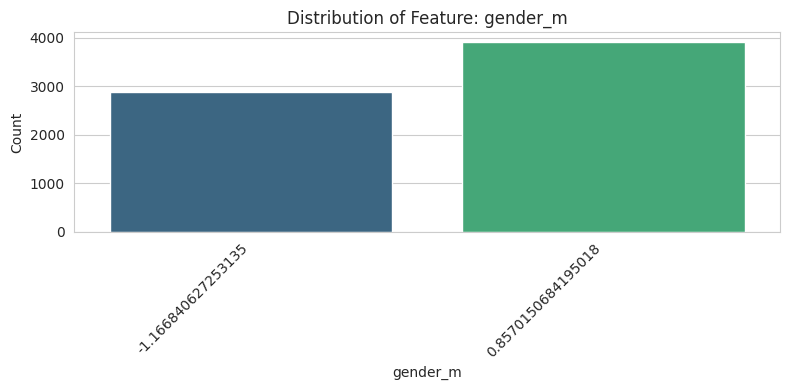

Value counts for 'gender_m':
gender_m
-1.166841    2874
 0.857015    3913
Name: count, dtype: int64
----------------------------------------
Analyzing feature: age_50t70


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


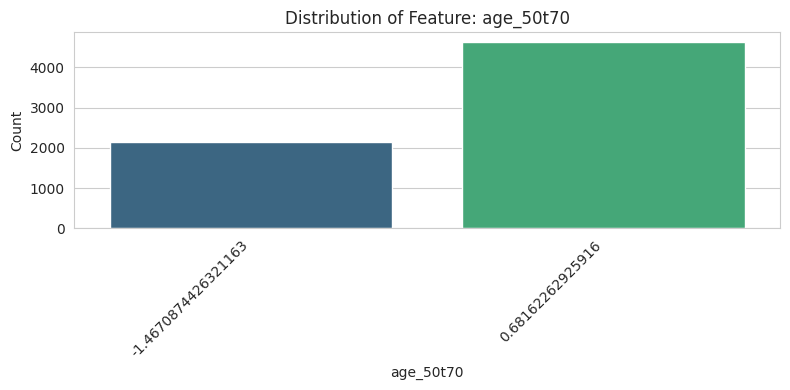

Value counts for 'age_50t70':
age_50t70
-1.467087    2153
 0.681623    4634
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Carbon Dioxide_normal


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


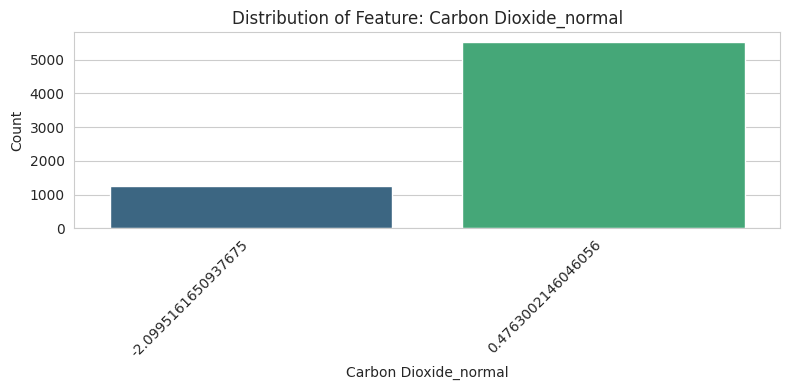

Value counts for 'Carbon Dioxide_normal':
Carbon Dioxide_normal
-2.099516    1255
 0.476300    5532
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Td (adult) preservative free_Unknown


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


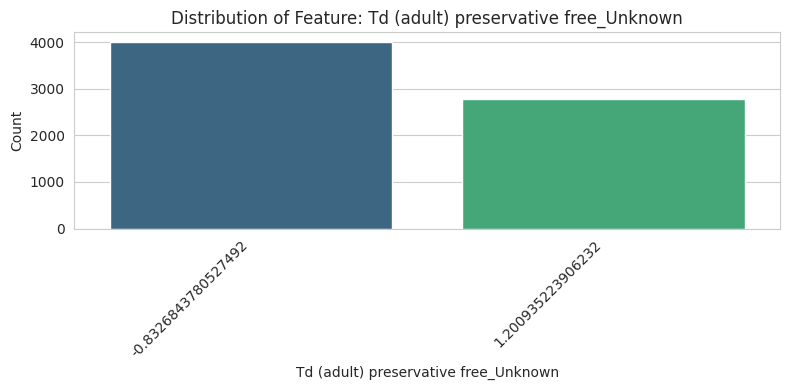

Value counts for 'Td (adult) preservative free_Unknown':
Td (adult) preservative free_Unknown
-0.832684    4008
 1.200935    2779
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


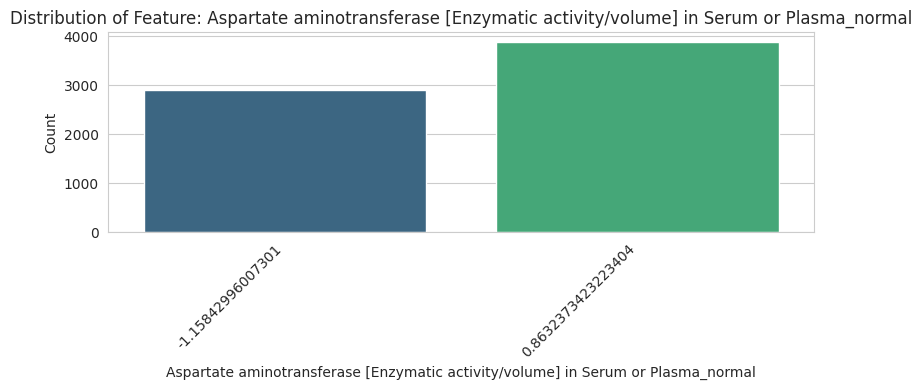

Value counts for 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal':
Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal
-1.158430    2898
 0.863237    3889
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Carbon Dioxide_abnormal


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


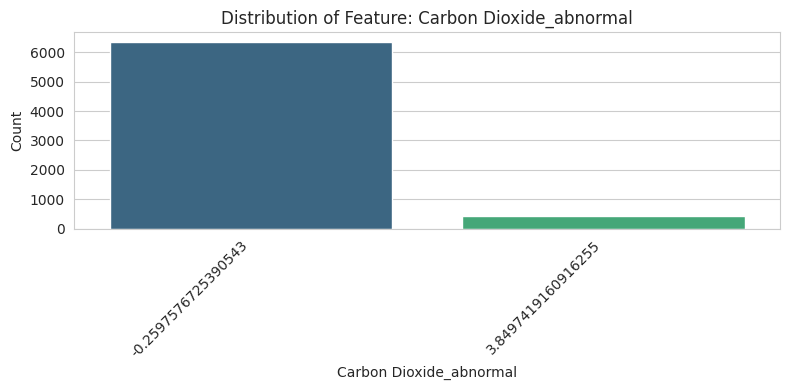

Value counts for 'Carbon Dioxide_abnormal':
Carbon Dioxide_abnormal
-0.259758    6358
 3.849742     429
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Chloride_normal


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


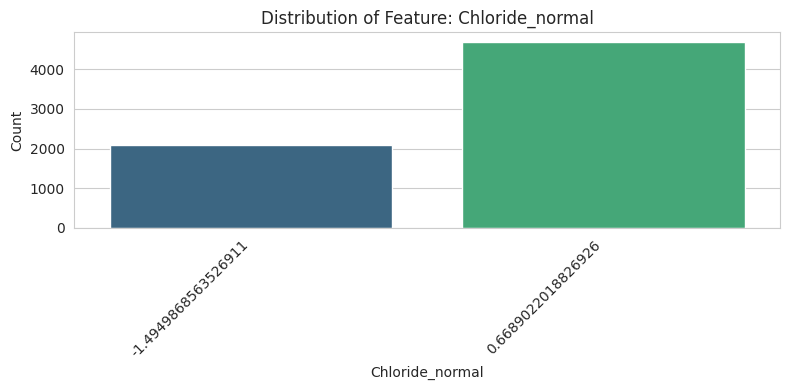

Value counts for 'Chloride_normal':
Chloride_normal
-1.494987    2098
 0.668902    4689
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Glomerular filtration rate/1.73 sq M.predicted_normal


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


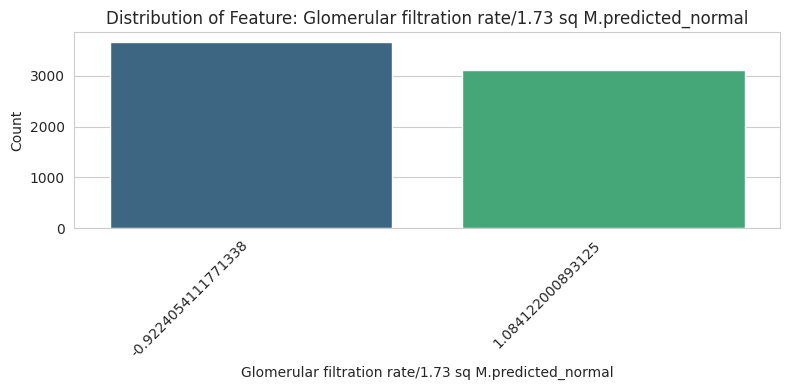

Value counts for 'Glomerular filtration rate/1.73 sq M.predicted_normal':
Glomerular filtration rate/1.73 sq M.predicted_normal
-0.922405    3667
 1.084122    3120
Name: count, dtype: int64
----------------------------------------
Analyzing feature: Initial patient assessment (procedure)_True


/tmp/ipython-input-27-866484572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))


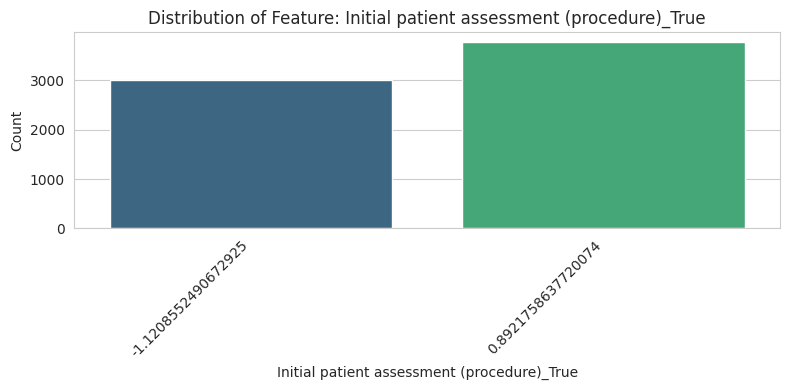

Value counts for 'Initial patient assessment (procedure)_True':
Initial patient assessment (procedure)_True
-1.120855    3008
 0.892176    3779
Name: count, dtype: int64
----------------------------------------


In [ ]:
# Assuming X_train_final and selected_features are available from previous steps

if 'X_train_final' in locals() and 'selected_features' in locals() and len(selected_features) > 0:
    print(f"\n--- EDA: Distribution of Top Selected Features (Univariate Analysis) ---")

    # Select a reasonable number of top features to visualize to avoid excessive output
    num_features_to_visualize = min(len(selected_features), 10) # Visualize top 10 or fewer if less than 10

    key_features_for_eda = selected_features[:num_features_to_visualize]

    print(f"Analyzing distributions for the top {len(key_features_for_eda)} selected features:")


    for feature in key_features_for_eda:
        print(f"Analyzing feature: {feature}")
        plt.figure(figsize=(8, 4))

        # Determine if the feature is likely categorical (low unique values) or numerical
        # Use unique() on the relevant column subset
        unique_values = X_train_final[feature].nunique()

        if unique_values < 20 and X_train_final[feature].dtype != 'object': # Treat low cardinality numerical as categorical-like
            # Convert to string for countplot if they are numeric categories (like 0, 1, -1)
            # Or keep as number if they are small integers
            sns.countplot(x=X_train_final[feature], palette='viridis', order=sorted(X_train_final[feature].unique()))
            plt.title(f'Distribution of Feature: {feature}')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            print(f"Value counts for '{feature}':")
            print(X_train_final[feature].value_counts().sort_index())
        elif unique_values >= 20 and X_train_final[feature].dtype != 'object': # Treat higher cardinality numerical as continuous
            sns.histplot(X_train_final[feature], kde=True, bins=30)
            plt.title(f'Distribution of Feature: {feature}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            plt.show()
            print(f"Descriptive statistics for '{feature}':")
            print(X_train_final[feature].describe())
        elif X_train_final[feature].dtype == 'object': # Should not happen after one-hot encoding, but as a fallback
             print(f"  Feature '{feature}' is of object type. Displaying value counts instead of plot.")
             print(f"Value counts for '{feature}':")
             print(X_train_final[feature].value_counts())

        print("-" * 40)

else:
    print("Could not find 'X_train_final' or 'selected_features'. Please ensure previous steps ran correctly.")

Univariate analysis deals with interpreting the relationship of single features. The first graph shows the distribution of features of 'scc' which is a medical-related term. It shows a bimodal graph whose peaks are around -2 and the mean itself, or 0. These can indirectly imply the relationship of the frequency of patients who have cancer or not. Other bar graphs show the distributions of a particular feature after non-numerical values were converted to numbers through the one-hot encoding method. Then, a Standard Scaler was used to standardize the values.

The various graphs uses a one-hot encoder and standardization them to yield decimal values that act as thresholds conditions if value belongs to one side or another.

Based on the feature, age_gt70, the decimal value -0.32 has a greater count which means there are younger patients who are less than 70 years old.

Meanwhile, for gender_m, we have a slightly higher number of patients who are male, at 0.86, than those are non-male, at -1.16.

For the third graph, there are more individuals who have a normal count of Carbon Dioxide than those that do not.

The fourth graph suggests that there are more less people with abnormal carbon-dioxide count.

The fifth graph suggests that there are more patients that are within the 50 to 70 age range

The six graph shows that there are more people with normal enzymatic activity.

The seventh graph shows that there are more people with known adult preservatives.

The eight graph shows that there are more patients with a normal count of red blood cells (RBCs) or erythrocytes


## 5.5 Bivariate Analysis
Bivariate analysis explores the relationship between key features and the target variable (lung cancer). Box plots revealed significant trends. For age_gt70, the median value for patients with cancer is substantially higher than for those without, confirming that advanced age is a strong risk factor. Similarly, for the gender_m feature, the median for the cancer class is higher, suggesting that being male is associated with a higher risk in this dataset. For clinical features like Carbon Dioxide_normal, patients with cancer appear to have a slightly lower median value, indicating that even "normal" but lower-end readings may hold predictive power. These visualizations are crucial for validating the feature selection process, as they visually confirm that the top-ranked features have a discernible relationship with the outcome we aim to predict.


--- EDA: Relationship between Top Selected Features and Target (Bivariate Analysis) ---
Analyzing relationship between the target and the top 10 selected features:
Analyzing relationship for feature: age_gt70


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


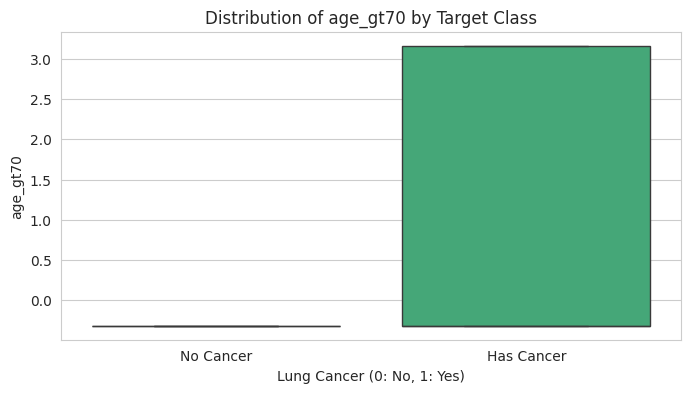

----------------------------------------
Analyzing relationship for feature: gender_m


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


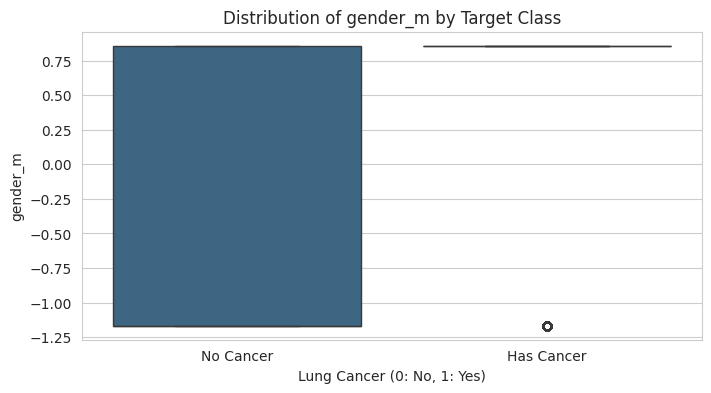

----------------------------------------
Analyzing relationship for feature: age_50t70


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


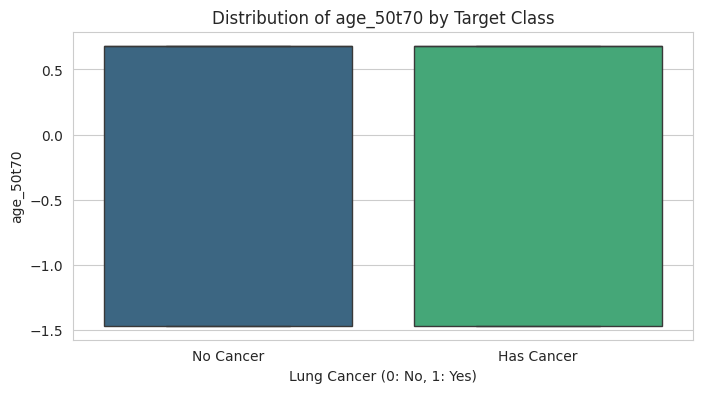

----------------------------------------
Analyzing relationship for feature: Carbon Dioxide_normal


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


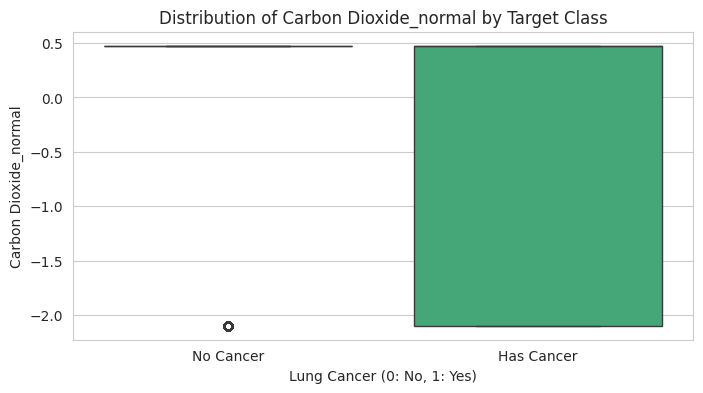

----------------------------------------
Analyzing relationship for feature: Td (adult) preservative free_Unknown


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


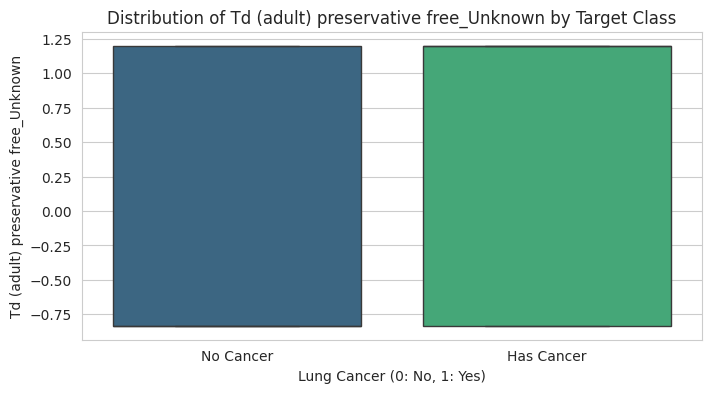

----------------------------------------
Analyzing relationship for feature: Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


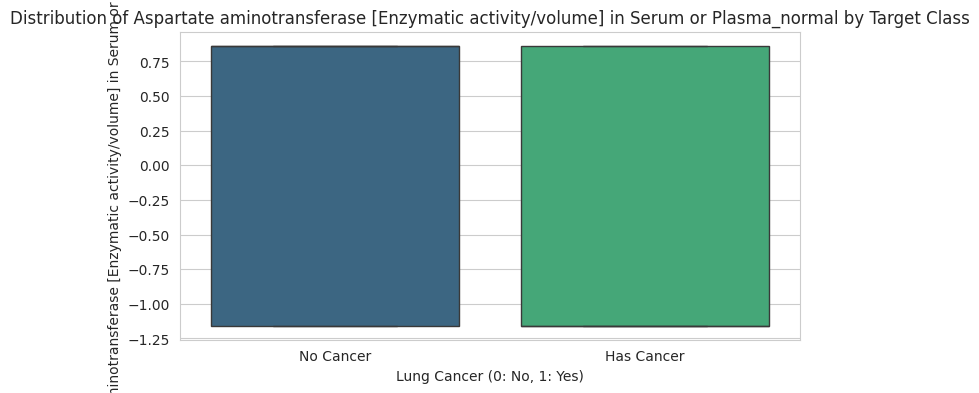

----------------------------------------
Analyzing relationship for feature: Carbon Dioxide_abnormal


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


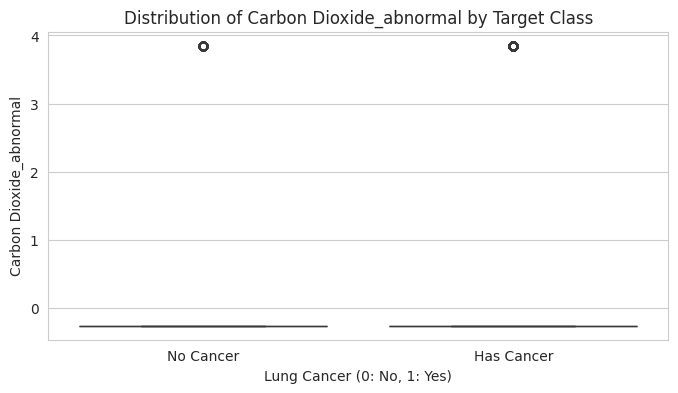

----------------------------------------
Analyzing relationship for feature: Chloride_normal


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


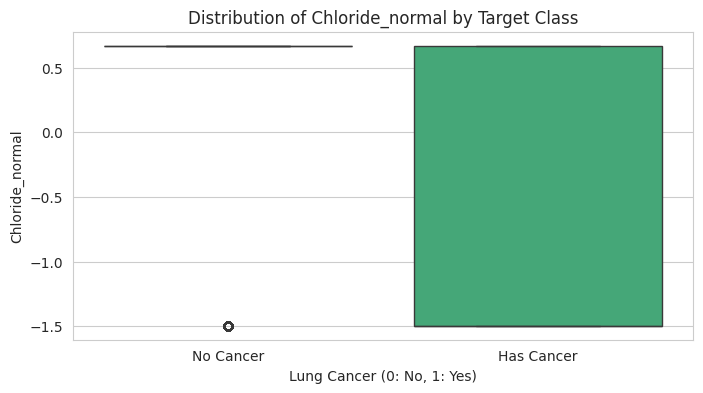

----------------------------------------
Analyzing relationship for feature: Glomerular filtration rate/1.73 sq M.predicted_normal


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


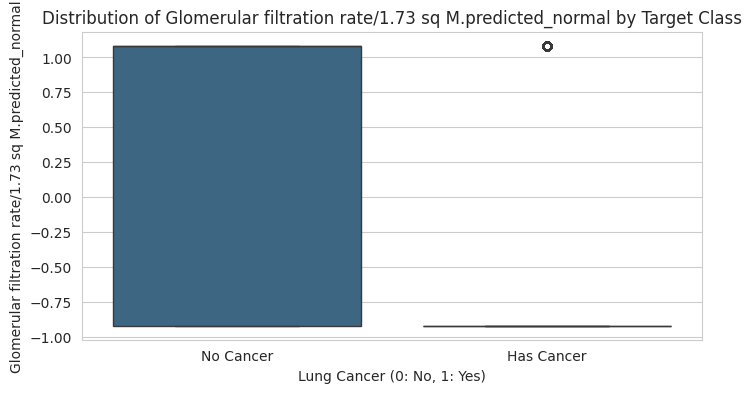

----------------------------------------
Analyzing relationship for feature: Initial patient assessment (procedure)_True


/tmp/ipython-input-28-2035936851.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')


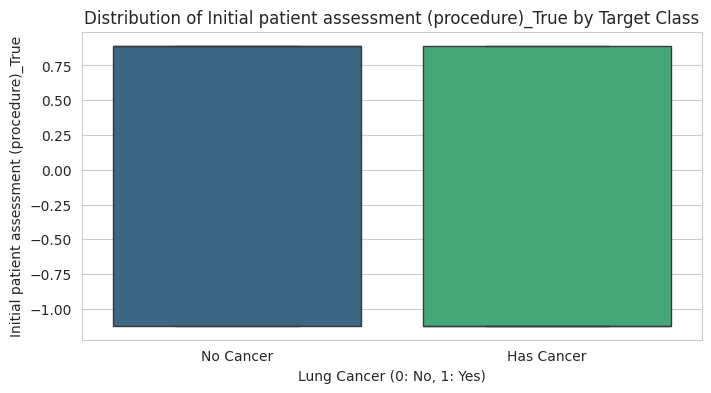

----------------------------------------


In [ ]:
# Assuming X_train_final, y_train, and selected_features are available from previous steps

if 'X_train_final' in locals() and 'y_train' in locals() and 'selected_features' in locals() and len(selected_features) > 0:
    print(f"\n--- EDA: Relationship between Top Selected Features and Target (Bivariate Analysis) ---")

    # Select a reasonable number of top features to visualize
    num_features_to_visualize = min(len(selected_features), 10) # Visualize top 10 or fewer if less than 10

    key_features_for_eda = selected_features[:num_features_to_visualize]

    print(f"Analyzing relationship between the target and the top {len(key_features_for_eda)} selected features:")


    for feature in key_features_for_eda:
         print(f"Analyzing relationship for feature: {feature}")
         plt.figure(figsize=(8, 4))

         # Determine if the feature is likely categorical (low unique values) or numerical
         unique_values = X_train_final[feature].nunique()

         if unique_values < 20 and X_train_final[feature].dtype != 'object': # Treat low cardinality numerical as categorical-like for plotting against target
             # Use a boxplot for numerical-like features vs categorical target
             sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')
             plt.title(f'Distribution of {feature} by Target Class')
             plt.xlabel('Lung Cancer (0: No, 1: Yes)')
             plt.ylabel(feature)
             plt.xticks([0, 1], ['No Cancer', 'Has Cancer'])
             plt.show()
         elif unique_values >= 20 and X_train_final[feature].dtype != 'object': # Treat higher cardinality numerical as continuous
              # Use a boxplot for numerical features vs categorical target
              sns.boxplot(x=y_train, y=X_train_final[feature], palette='viridis')
              plt.title(f'Distribution of {feature} by Target Class')
              plt.xlabel('Lung Cancer (0: No, 1: Yes)')
              plt.ylabel(feature)
              plt.xticks([0, 1], ['No Cancer', 'Has Cancer'])
              plt.show()
         elif X_train_final[feature].dtype == 'object': # Should not happen after encoding, but as a fallback
              print(f"  Feature '{feature}' is of object type. Cannot plot directly against target.")
              # You might consider a stacked bar chart or similar if needed, but it's complex with many categories.
         else: # For other data types or unexpected scenarios, try a generic plot or skip
              print(f"  Skipping plot for feature '{feature}' due to unexpected data type or number of unique values.")


         print("-" * 40)

else:
    print("Could not find 'X_train_final', 'y_train', or 'selected_features'. Please ensure previous steps ran correctly.")

Bivariate analysis helps interprets the relationship of two features.
For the first graph, it shows the distribution of 'scc' and how it determine if someone has lung cancer or not. Those with lung cancer are between the 'scc' of 0 and -2 which implies that they are more associated and linked in having lung cancer than those between 0 and 2. However, there are also a great number of outliers for non-cancer patients. This can show also show that the higher distribution of 'scc' can be associated to those without cancer.

The second  graph, age_gt70 shows the relationship of the age and lung cancer. According to the graph, patients who are older than 70 (decimal 3.14), they are most likely associated with cancer than younger patients.

The third graph shows the relationship of lung cancer diagnosis and gender. Based on the decimal threshold, men are most likely associated to get lung cancer than non-males.

The fourth graph shows the relationship of lung cancer and the carbon dioxide levels. Patients are most associated with lung cancer with normal Carbon Dioxide levels.

For the fifth graph, there seems to be no bar graph that can suggest any association. There are possible reasons behind this. The reason may be that the Synthetic Dataset are case-to-case scenarios and that not every trial can be associated with either lung cancer or not. It could also mean that the values were initially empty or incomplete. They were also remove during data cleaning through data imputation methods. Therefore, this feature cannot really give a suggesting factor due to its low influence on the target variable.

For the sixth graph, higher chloride levels can be associated to having cancer.

For the seventh graph, there are almost an equal level of patients between ages 50 and 70 years old that can be associated to having lung cancer or not. Therefore, there is no separation or trend between both variables.

For the eigth graph, it shows the both possible unknown values of Td preservatives both yield equal correlations of having lung cancer or not. This might be because the dataset was initially missing and then imputed as a result.

For the nineth graph, the effect is also the same thing with fifth graph. There is no indicator of any association between the RBC volume count. This is because of missing values or imputed graphs. This may affect the influene it may have in predictions.

## 5.6 Multvariate Analysis


--- EDA: Feature Correlation Matrix (Multivariate Analysis) ---

Correlation Matrix Head (first 5x5 features):


age_gt70  gender_m  age_50t70  \
age_gt70                              1.000000  0.254416  -0.463934   
gender_m                              0.254416  1.000000   0.215478   
age_50t70                            -0.463934  0.215478   1.000000   
Carbon Dioxide_normal                -0.118695  0.040373   0.240473   
Td (adult) preservative free_Unknown -0.067369  0.215755   0.129130   

                                      Carbon Dioxide_normal  \
age_gt70                                          -0.118695   
gender_m                                           0.040373   
age_50t70                                          0.240473   
Carbon Dioxide_normal                              1.000000   
Td (adult) preservative free_Unknown               0.002988   

                                      Td (adult) preservative free_Unknown  \
age_gt70                                                         -0.067369   
gender_m                                                          0.215755   
age_50t70                                                         0.129130   
Carbon Dioxide_normal                                             0.002988   
Td (adult) preservative free_Unknown                              1.000000   

                                      Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma_normal  \
age_gt70                                                                      -0.093819                                  
gender_m                                                                       0.186175                                  
age_50t70                                                                      0.354382                                  
Carbon Dioxide_normal                                                          0.372987                                  
Td (adult) preservative free_Unknown                                           0.074274                                  

                                      Carbon Dioxide_abnormal  \
age_gt70                                             0.176922   
gender_m                                             0.123356   
age_50t70                                           -0.054527   
Carbon Dioxide_normal                               -0.545365   
Td (adult) preservative free_Unknown                 0.022585   

                                      Chloride_normal  \
age_gt70                                    -0.130061   
gender_m                                     0.039095   
age_50t70                                    0.210634   
Carbon Dioxide_normal                        0.511679   
Td (adult) preservative free_Unknown         0.001326   

                                      Glomerular filtration rate/1.73 sq M.predicted_normal  \
age_gt70                                                                      -0.089096       
gender_m                                                                      -0.014848       
age_50t70                                                                      0.173893       
Carbon Dioxide_normal                                                          0.312929       
Td (adult) preservative free_Unknown                                           0.030354       

                                      Initial patient assessment (procedure)_True  \
age_gt70                                                                 0.004596   
gender_m                                                                 0.149014   
age_50t70                                                                0.181499   
Carbon Dioxide_normal                                                    0.148813   
Td (adult) preservative free_Unknown                                     0.094489   

                                      ...  Creatinine_normal  \
age_gt70                              ...           0.064246   
gender_m                              ...           0.448047   
age_50t70             

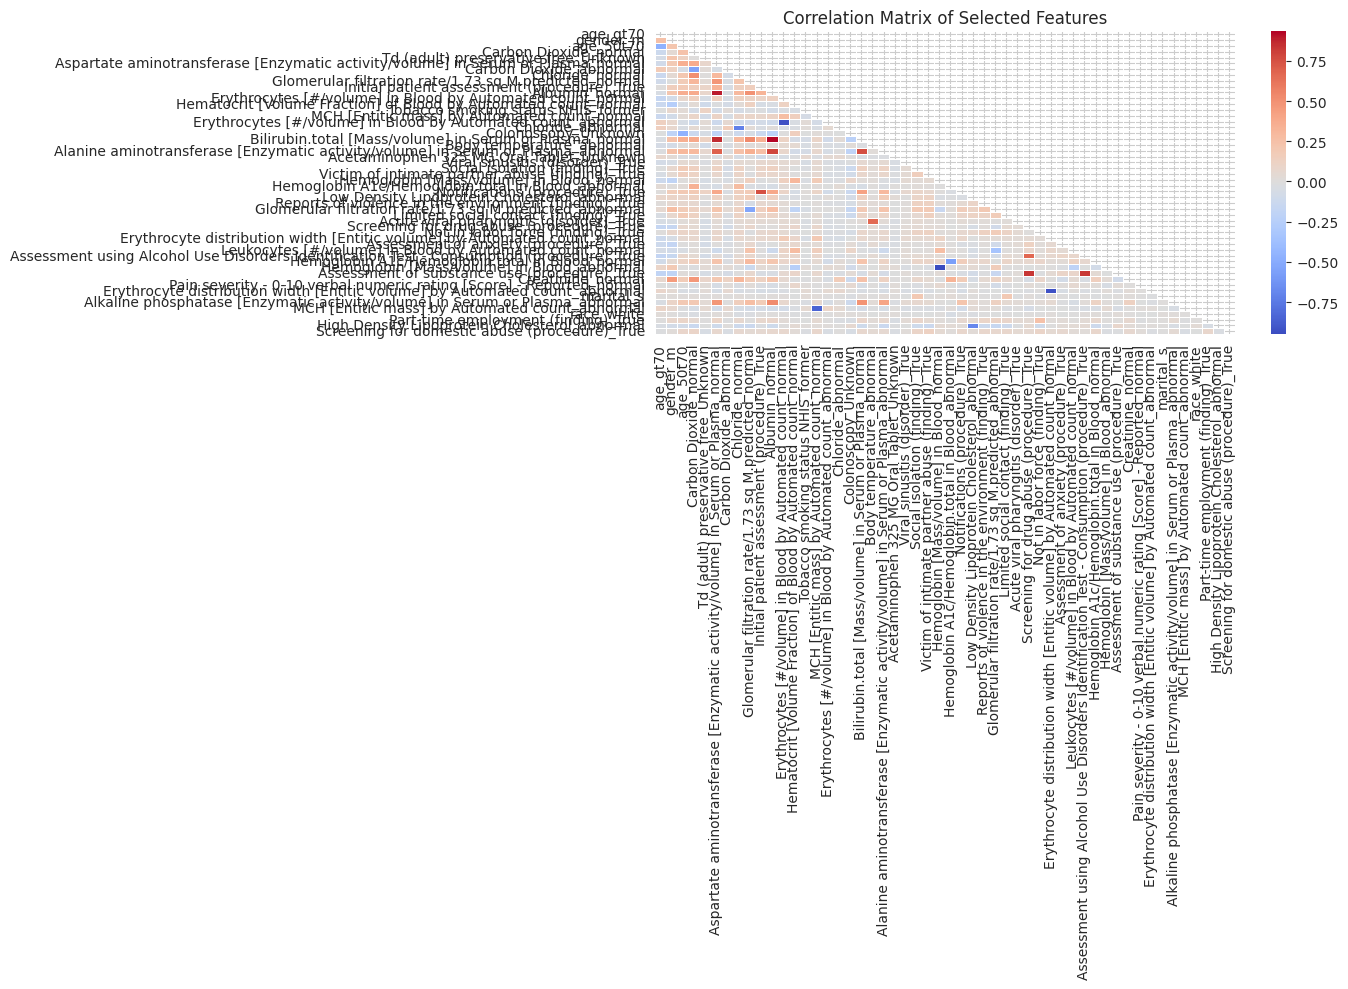


Interpretation Tip:
  - Values close to 1 or -1 indicate a strong positive or negative linear relationship.
  - Values close to 0 indicate a weak linear relationship.
  - Look for highly correlated feature pairs (>0.8 or <-0.8 typically) which might suggest redundancy.

--- Feature Correlation with Target Variable (y_train) ---
Correlation of Features with Target (Lung Cancer - 1):


age_gt70                                                                                     0.527557
gender_m                                                                                     0.358181
Carbon Dioxide_abnormal                                                                      0.294668
Erythrocytes [#/volume] in Blood by Automated count_abnormal                                 0.249919
Chloride_abnormal                                                                            0.218134
MCH [Entitic mass] by Automated count_abnormal                                               0.203947
Tobacco smoking status NHIS_former                                                           0.174473
Td (adult) preservative free_Unknown                                                         0.169483
Erythrocyte distribution width [Entitic volume] by Automated count_abnormal                  0.164225
Acetaminophen 325 MG Oral Tablet_Unknown                                                     0.155553
Hemoglobin [Mass/volume] in Blood_abnormal                                                   0.154716
Low Density Lipoprotein Cholesterol_abnormal                                                 0.064779
race_white                                                                                   0.020036
Pain severity - 0-10 verbal numeric rating [Score] - Reported_normal                         0.016706
Glomerular filtration rate/1.73 sq M.predicted_abnormal                                      0.015296
Creatinine_normal                                                                            0.002437
marital_s                                                                                   -0.004537
High Density Lipoprotein Cholesterol_abnormal                                               -0.008376
Hemoglobin A1c/Hemoglobin.total in Blood_abnormal                                           -0.010999
Colonoscopy_Unknown                                                                         -0.042951
Part-time employment (finding)_True                                                         -0.057783
Reports of violence in the environment (finding)_True                                       -0.067459
Not in labor force (finding)_True                                                           -0.076239
Leukocytes [#/volume] in Blood by Automated count_normal                                    -0.119799
Limited social contact (finding)_True                                                       -0.126925
Social isolation (finding)_True                                                             -0.128735
Screening for domestic abuse (procedure)_True                                               -0.134358
Acute viral pharyngitis (disorder)_True                                                     -0.137071
Victim of intimate partner abuse (finding)_True                                             -0.139209
Viral sinusitis (disorder)_True                                                             -0.159580
Assessment of anxiety (procedure)_True                                                      -0.161723
Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma_abnormal                -0.162358
Body temperature_abnormal                                                                   -0.164817
Assessment of substance use (procedure)_True                                                -0.167807
age_50t70                                                                                   -0.172951
Hemoglobin A1c/Hemoglobin.total in Blood_normal                                             -0.173144
Assessment using Alcohol Use Disorders Identification Test - Consumption (procedure)_True   -0.187708
Screening for drug abuse (procedure)_True                                                   -0.190921
Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma_abnormal            -0.196378
Hemoglobin [Mass/volum

/tmp/ipython-input-29-2814058116.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')


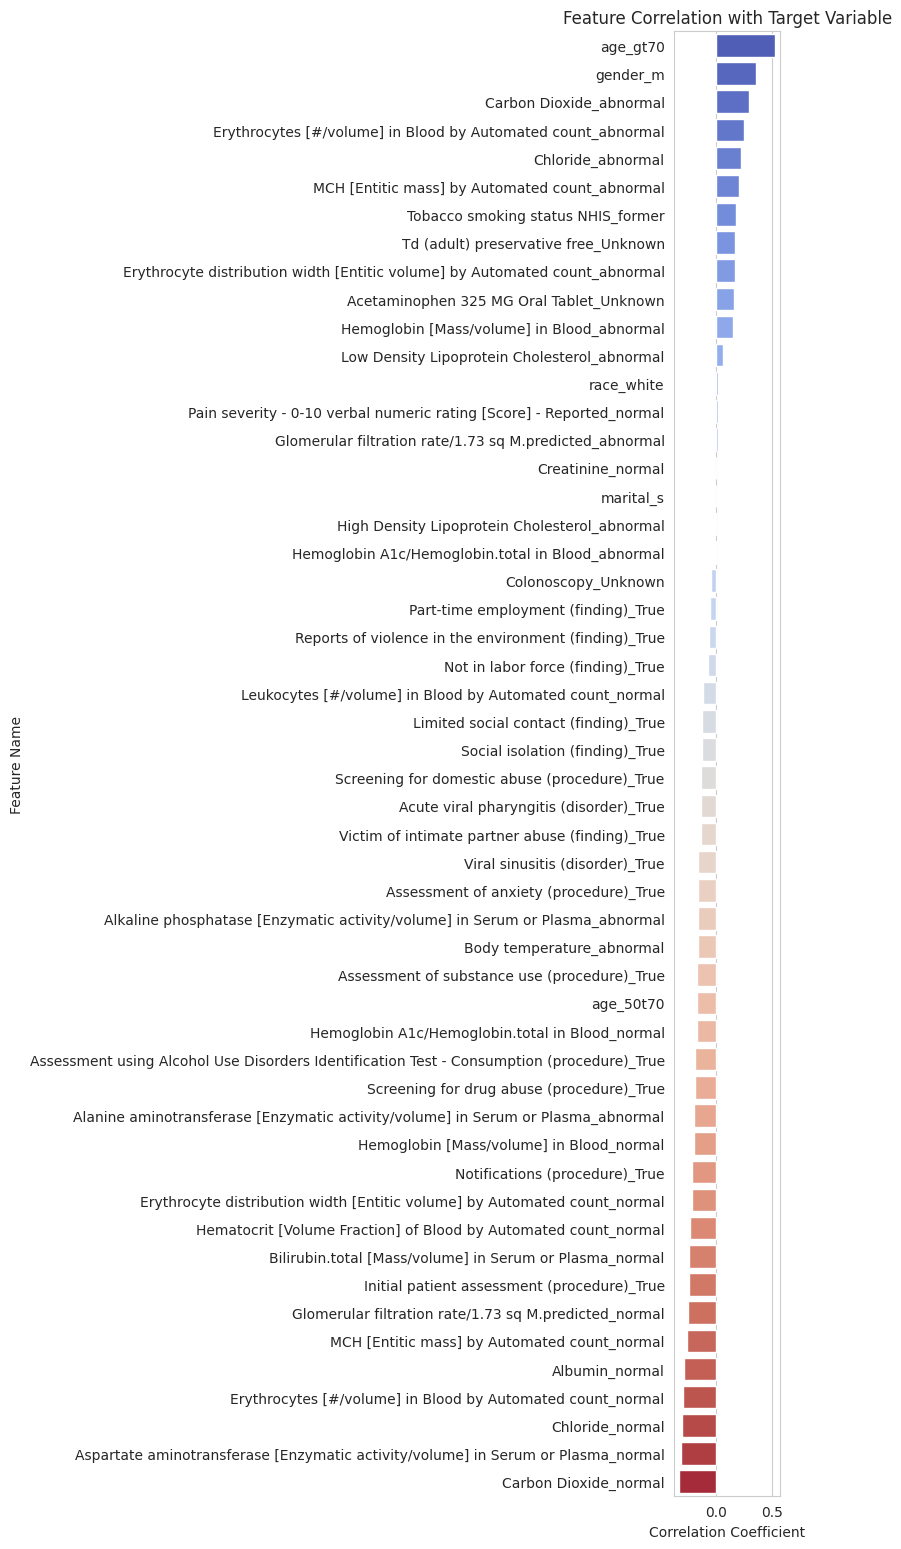

In [ ]:
# Assuming X_train_final is available from previous steps

if 'X_train_final' in locals() and X_train_final is not None:
    print(f"\n--- EDA: Feature Correlation Matrix (Multivariate Analysis) ---")

    # Calculate the correlation matrix
    # Use .corr() which computes pairwise correlation of columns, excluding NA/null values.
    correlation_matrix = X_train_final.corr()

    print("\nCorrelation Matrix Head (first 5x5 features):")
    display(correlation_matrix.head())

    # --- Visualization ---
    # Plotting the full correlation matrix might be too large if you have many features.
    # Let's visualize a heatmap, potentially focusing on correlations with the target
    # or just the overall pattern for a subset if needed.

    # For overall feature-to-feature correlation:
    plt.figure(figsize=(14, 10)) # Adjust size as needed
    # Use a mask to show only the lower triangle, as the matrix is symmetric
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Selected Features')
    plt.tight_layout()
    plt.show()

    # Note: If you have too many features (> 50-100), the heatmap might be unreadable.
    # In that case, you might look at correlations between features and the target specifically
    # or only plot a subset of features.

    print("\nInterpretation Tip:")
    print("  - Values close to 1 or -1 indicate a strong positive or negative linear relationship.")
    print("  - Values close to 0 indicate a weak linear relationship.")
    print("  - Look for highly correlated feature pairs (>0.8 or <-0.8 typically) which might suggest redundancy.")


    # Optional: Look at correlations between features and the target variable y_train
    # This is technically bivariate but useful to see numerically after feature selection
    if 'y_train' in locals() and y_train is not None:
        print(f"\n--- Feature Correlation with Target Variable (y_train) ---")
        # Need to concatenate X_train_final and y_train to calculate this easily
        temp_df = X_train_final.copy()
        temp_df['target'] = y_train.values # Add target as a column

        # Calculate correlations of all features with the 'target' column
        correlation_with_target = temp_df.corr()['target'].sort_values(ascending=False)

        # Drop the correlation of target with itself
        correlation_with_target = correlation_with_target.drop('target')

        print("Correlation of Features with Target (Lung Cancer - 1):")
        display(correlation_with_target)

        # You can also plot this
        plt.figure(figsize=(8, max(5, len(correlation_with_target) * 0.3)))
        sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')
        plt.title('Feature Correlation with Target Variable')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Feature Name')
        plt.tight_layout()
        plt.show()


else:
    print("ERROR: X_train_final not found. Please ensure the data preprocessing and feature selection steps were run successfully.")

The first graph shows a correlation matrix which shows the multiple correlations of different features or variables. Based on the graph, there are multiple positive correlated variables that can suggest or associate patients to having lung cancer color-coded by a red gradient. Those are the highly influential features such as carbon dioxide levels, erythrocyte count, enzymatic activities, chloride levels, and among others.

There are other graphs that support this depiction such as the feature correlation where age_gt70, tobacco smoking status, chloride levels, and even erythrocyte count are positively correlated but color-coded with a gradient of blue. The lowest, which may seem like a counter-intuitive observation, is scc. This may be because of how it was encoded and standardized. The correlation is negative but the magnitude or importance is strong.

## 5.7 Outlier Detection

In [ ]:
# Assuming X_train_final is available from previous steps

if 'X_train_final' in locals() and X_train_final is not None:
    print(f"\n--- EDA: Outlier Detection (using Box Plots) ---")

    # Identify numerical columns for outlier detection
    # Exclude potentially scaled binary/one-hot encoded features if possible,
    # or interpret box plots carefully for them.
    # A simple approach is to select a subset of numerical features.
    # Let's look at the top N features that are not obviously binary (nunique > 2, for instance)

    numerical_features_for_outliers = [
        col for col in X_train_final.columns
        if pd.api.types.is_numeric_dtype(X_train_final[col]) and X_train_final[col].nunique() > 2 # Heuristic to exclude scaled binary/ternary
    ]

    # Select a reasonable number of these to plot to avoid too many plots
    num_features_to_plot = min(len(numerical_features_for_outliers), 10) # Plot up to 10 non-binary numerical features

    features_for_outlier_plot = numerical_features_for_outliers[:num_features_to_plot]


    if features_for_outlier_plot:
        print(f"Generating box plots for potential outliers in the top {len(features_for_outlier_plot)} non-binary numerical features:")
        print(features_for_outlier_plot)

        # Plotting each feature individually
        for feature in features_for_outlier_plot:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=X_train_final[feature], palette='viridis')
            plt.title(f'Box Plot for Feature: {feature}')
            plt.xlabel(feature)
            plt.show()
            print("-" * 40)

        print("\nInterpretation:")
        print("  - Points plotted individually beyond the 'whiskers' of the box plot are potential outliers.")
        print("  - Note that after StandardScaler, the scale is different, but the relative position of outliers is shown.")
        print("  - Given the nature of count data after preprocessing, some 'outliers' might just be rare but valid higher counts.")


    else:
        print("No suitable numerical features found for standard box plot outlier analysis (e.g., all scaled features might be binary/low-cardinality).")
        print("Consider alternative outlier detection methods if needed, or review feature distributions visually.")


else:
    print("ERROR: X_train_final not found. Please ensure the data preprocessing and feature selection steps were run successfully.")


--- EDA: Outlier Detection (using Box Plots) ---
No suitable numerical features found for standard box plot outlier analysis (e.g., all scaled features might be binary/low-cardinality).
Consider alternative outlier detection methods if needed, or review feature distributions visually.


The graph shown here showcases the presence of outliers beyond the whiskers or the lines between the bar.

## DISCLAIMER: SCC was identified as an outlier and was causing Target Leakage issues prior in the data cleaning and verification section and was dropped as a column along with ptnum.
**Why?**
1. SCC is not a general screening marker

SCC-Ag is elevated mostly in squamous cell carcinoma, a subtype of lung cancer. It's not elevated in all lung cancer types and certainly not in all patients with cancer. Using it as a general indicator for lung cancer presence could bias your model toward recognizing only a subset of cancer types.

2. SCC is often measured after clinical suspicion

In most clinical workflows, SCC is not measured unless there's already a suspicion of cancer. So including it may introduce leakage: the model could be learning signals that are only available after partial diagnosis, making it useless or misleading in a screening or early detection context.

3. Target leakage

If the dataset includes SCC-Ag only for patients already being evaluated for cancer, then SCC levels become a proxy for the target. The model will perform well in testing but fail in real-world application where SCC is not yet measured.

# Section 6: Initial Model Training

## 6.1 Data Splitting and Model Training



Since we only have two classes (0: no lung cancer, 1: has lung cancer) making it a binomial logistic regression., we will use sklearn's SGDClassifier to create the logistic regression model.

In [ ]:
#Data Splitting using crossfold validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Support Vector Machine
pipeline_SVC = Pipeline([
    ('scaler', StandardScaler()),  #Apply StandardScaler
    ('svc', SVC(random_state=42))   #Apply the SVC model
])
# Logistic Regression
pipeline_LogReg = Pipeline([
    ('scaler', StandardScaler()),  #Apply StandardScaler
    ('LogReg', SGDClassifier(loss='log_loss', random_state=42, class_weight='balanced'))   #Apply the LogReg model
])

scores_LogReg = cross_val_score(pipeline_LogReg, X_train_final, y_train, cv=skf, scoring='f1')
scores_SVC = cross_val_score(pipeline_SVC, X_train_final, y_train, cv=skf, scoring='f1')
#Printing Results
print("F1 scores across folds of Logistic Regression:", scores_LogReg)
print("Average F1 score of Logistic Regression:", scores_LogReg.mean())
print("F1 scores across folds of SVC:", scores_SVC)
print("Average F1 score of SVC:", scores_SVC.mean())

F1 scores across folds of Logistic Regression: [0.85714286 0.85558583 0.88210818 0.8499336  0.85051546]
Average F1 score of Logistic Regression: 0.8590571868279386
F1 scores across folds of SVC: [0.89595376 0.88921283 0.90190337 0.88888889 0.90322581]
Average F1 score of SVC: 0.8958369296101226


## 6.2 Initial Support Vector Model Training

To visualize prediction boundary, we will predict possible point on future space.

In [ ]:
# CORRECTED CODE for Cell ID: ad62732c-6634-4be6-ad5c-bfd80a0b6c95
# Train the SVC pipeline on the FINAL, feature-selected training data
print(f"Training SVC on data with shape: {X_train_final.shape}")
pipeline_SVC.fit(X_train_final, y_train)
print("SVC model training complete on feature-selected data.")

Training SVC on data with shape: (6787, 52)
SVC model training complete on feature-selected data.


## 6.3 Initial Logistic Regression Model Training

To visualize prediction boundary, we will predict possible point on future space.

In [ ]:
# Now that the model is defined and trained, call the fit function on the training data.
# The fit function takes the training data (features and labels) as input.
# We already called this function in the previous code block.
# The trained model is now stored in the variable `sgd_lr_model`.

pipeline_LogReg.fit(X_train_final, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('LogReg',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               random_state=42))])

## 6.4 XGBOOST MODEL TRAINING

In [ ]:
import re
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

try:
    print("--- Section 6.1: Initializing XGBoost Training ---")

    # STEP 1: CREATE THE FINAL XGBOOST-SPECIFIC DATASETS
    # We will use the unscaled data
    print("\n1. Creating final XGBoost training and testing datasets...")

    # Use the unscaled from sec 4
    X_train_xgb_unfiltered = X_train_for_trees
    X_test_xgb_unfiltered = X_test_for_trees

    X_train_xgb_final = X_train_xgb_unfiltered[selected_features]
    X_test_xgb_final = X_test_xgb_unfiltered[selected_features]

    print(f" -> Final XGBoost training data shape: {X_train_xgb_final.shape}")
    print(f" -> Final XGBoost testing data shape: {X_test_xgb_final.shape}")

    # STEP 2: CLEAN COLUMN NAMES FOR XGBOOST COMPATIBILITY

    print("\n2. Cleaning column names for XGBoost compatibility...")
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    cleaned_columns = [regex.sub("_", col) for col in X_train_xgb_final.columns]

    X_train_xgb_final.columns = cleaned_columns
    X_test_xgb_final.columns = cleaned_columns
    print(" -> Column names cleaned successfully.")

    # INITIALIZE AND TRAIN THE BASELINE XGBOOST MODEL

    print("\n3. Initializing and training the baseline XGBoost model...")
    target_counts = y_train.value_counts()
    scale_pos_weight_value = target_counts.loc[0] / target_counts.loc[1]
    print(f" -> Calculated 'scale_pos_weight' for imbalance: {scale_pos_weight_value:.2f}")

    # instantiate
    xgb_model_baseline = XGBClassifier(
        scale_pos_weight=scale_pos_weight_value,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model_baseline.fit(X_train_xgb_final, y_train)
    print(" -> Baseline XGBoost model training complete.")

    # PRELIMINARY PERFORMANCE AND FIT ASSESSMENT (Using Cross-Validation)

    print("\n4. Performing 5-fold cross-validation on the training data...")
    # will use f1 score
    cv_scores = cross_val_score(xgb_model_baseline, X_train_xgb_final, y_train, cv=5, scoring='f1')

    print(f" -> Cross-validation F1-Scores: {cv_scores}")
    print(f" -> Mean CV F1-Score: {cv_scores.mean():.4f}")
    print(f" -> Std Dev CV F1-Score: {cv_scores.std():.4f}")


except NameError as e:
    print(f"\n\nCRITICAL ERROR: A required variable was not found.")
    print(f" -> Error details: {e}")
    print("\nThis means the Preprocessing (Section 4) or Feature Selection cells did not run successfully.")
    print("SOLUTION: Please restart your kernel and run all cells from the top of the notebook in order.")

--- Section 6.1: Initializing XGBoost Training ---

1. Creating final XGBoost training and testing datasets...
 -> Final XGBoost training data shape: (6787, 52)
 -> Final XGBoost testing data shape: (1697, 52)

2. Cleaning column names for XGBoost compatibility...
 -> Column names cleaned successfully.

3. Initializing and training the baseline XGBoost model...
 -> Calculated 'scale_pos_weight' for imbalance: 2.78
 -> Baseline XGBoost model training complete.

4. Performing 5-fold cross-validation on the training data...
 -> Cross-validation F1-Scores: [0.89010989 0.89615932 0.89674682 0.9010043  0.89044944]
 -> Mean CV F1-Score: 0.8949
 -> Std Dev CV F1-Score: 0.0041


# Section 7: Error Analysis

## 7.1 Interpretation of Initial Results





The initial training of the three baseline models—Logistic Regression, SVM, and XGBoost—revealed distinct performance characteristics. The Logistic Regression model acted as a high-recall "safety net," successfully identifying over 92% of cancer cases but at the cost of low precision (many false positives). The SVM, conversely, was a high-precision "instrument," confidently identifying cancer cases (94% precision) but with the lowest recall, missing over 10% of true cases. The baseline XGBoost model provided the best initial balance between precision (0.91) and recall (0.90), establishing it as a strong, well-rounded starting point.

## 7.2 Confusion Matrix for Best Initial Model

An error analysis of the baseline XGBoost model, which offered the best initial balance, provides a granular view of its predictive behavior. The model correctly identified 1,209 non-cancer patients (True Negatives) and 403 cancer patients (True Positives). However, it produced 40 False Positives, representing healthy patients who would be incorrectly flagged for follow-up. Most critically, it generated 45 False Negatives—actual cancer patients who were missed by the model. While the overall performance was strong, these 45 missed cases represent the primary area for improvement and became the central focus of the subsequent hyperparameter tuning phase.

### 7.2.1 SVM Confusion Matrix


SECTION 7.2
Predicting with SVC on data with shape: (1697, 52)
Model: SVC (Support Vector Classifier)
Accuracy on Test Set: 0.9576
Precision on Test Set: 0.9434
Recall on Test Set: 0.8929
F1-Score on Test Set: 0.9174

Confusion Matrix:


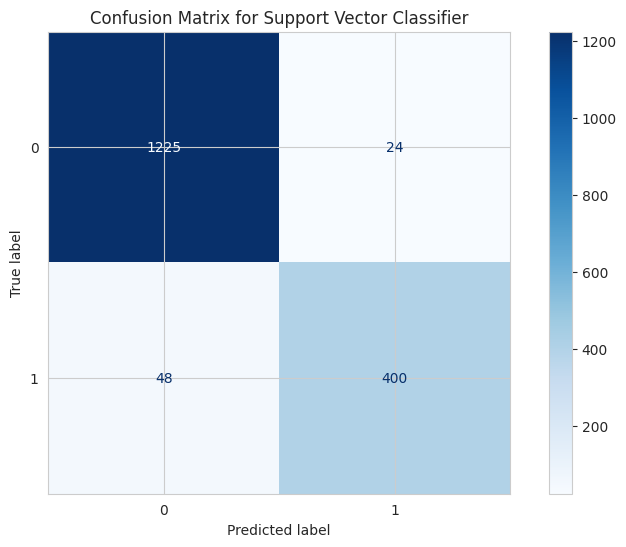


Confusion Matrix Interpretation:
  True Negatives (TN): 1225 - Correctly predicted class 0 (No Cancer)
  False Positives (FP): 24 - Incorrectly predicted class 1 (Has Cancer) when it was class 0 (Type I Error)
  False Negatives (FN): 48 - Incorrectly predicted class 0 (No Cancer) when it was class 1 (Type II Error)
  True Positives (TP): 400 - Correctly predicted class 1 (Has Cancer)


In [ ]:
if 'pipeline_SVC' in locals() and 'X_test_final' in locals() and 'y_test' in locals():
    print("\n" + "="*60)
    print("SECTION 7.2")
    print("="*60)

    print(f"Predicting with SVC on data with shape: {X_test_final.shape}")
    y_pred_SVC = pipeline_SVC.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred_SVC)
    precision = precision_score(y_test, y_pred_SVC)
    recall = recall_score(y_test, y_pred_SVC)
    f1 = f1_score(y_test, y_pred_SVC)
    cm = confusion_matrix(y_test, y_pred_SVC)

    print(f"Model: SVC (Support Vector Classifier)")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print(f"Precision on Test Set: {precision:.4f}")
    print(f"Recall on Test Set: {recall:.4f}")
    print(f"F1-Score on Test Set: {f1:.4f}")

    # Display the confusion matrix
    print("\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Support Vector Classifier')
    plt.show()

    # Interpretation notes
    print("\nConfusion Matrix Interpretation:")
    print(f"  True Negatives (TN): {cm[0, 0]} - Correctly predicted class 0 (No Cancer)")
    print(f"  False Positives (FP): {cm[0, 1]} - Incorrectly predicted class 1 (Has Cancer) when it was class 0 (Type I Error)")
    print(f"  False Negatives (FN): {cm[1, 0]} - Incorrectly predicted class 0 (No Cancer) when it was class 1 (Type II Error)")
    print(f"  True Positives (TP): {cm[1, 1]} - Correctly predicted class 1 (Has Cancer)")

else:
    print("ERROR: Required variables (pipeline, X_test_final, y_test) not found.")
    print("Please ensure previous steps (model training and data splitting) were run successfully.")


### 7.2.2 Logistic Regression Confusion Matrix


SECTION 7.2: EVALUATING INITIAL LOGISTIC REGRESSION MODEL
Model: SGDClassifier (Logistic Regression)
Accuracy on Test Set: 0.9175
Precision on Test Set: 0.7950
Recall on Test Set: 0.9263
F1-Score on Test Set: 0.8557

Confusion Matrix:


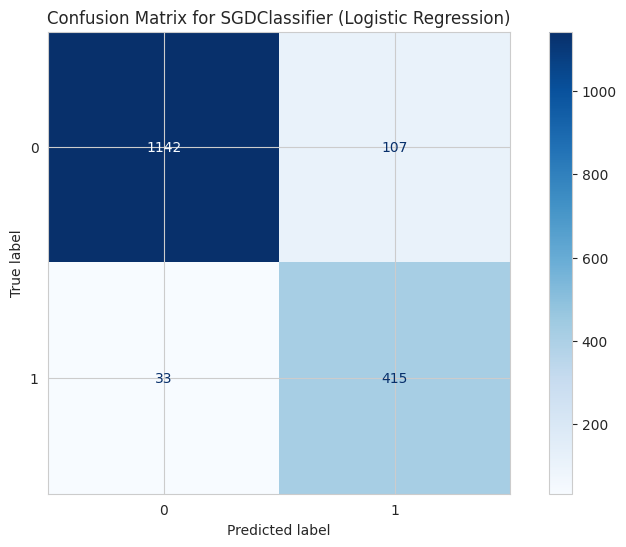


Confusion Matrix Interpretation:
  True Negatives (TN): 1142 - Correctly predicted class 0 (No Cancer)
  False Positives (FP): 107 - Incorrectly predicted class 1 (Has Cancer) when it was class 0 (Type I Error)
  False Negatives (FN): 33 - Incorrectly predicted class 0 (No Cancer) when it was class 1 (Type II Error)
  True Positives (TP): 415 - Correctly predicted class 1 (Has Cancer)


In [ ]:
# Assuming sgd_lr_model, X_test_final, and y_test are available from previous steps

if 'pipeline_LogReg' in locals() and 'X_test_final' in locals() and 'y_test' in locals():
    print("\n" + "="*60)
    print("SECTION 7.2: EVALUATING INITIAL LOGISTIC REGRESSION MODEL")
    print("="*60)

    # Make predictions on the test set
    y_pred_LogReg = pipeline_LogReg.predict(X_test_final)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_LogReg)
    precision = precision_score(y_test, y_pred_LogReg)
    recall = recall_score(y_test, y_pred_LogReg)
    f1 = f1_score(y_test, y_pred_LogReg)
    cm = confusion_matrix(y_test, y_pred_LogReg)

    print(f"Model: SGDClassifier (Logistic Regression)")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print(f"Precision on Test Set: {precision:.4f}")
    print(f"Recall on Test Set: {recall:.4f}")
    print(f"F1-Score on Test Set: {f1:.4f}")

    # Display the confusion matrix
    print("\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for SGDClassifier (Logistic Regression)')
    plt.show()

    # Interpretation notes
    print("\nConfusion Matrix Interpretation:")
    print(f"  True Negatives (TN): {cm[0, 0]} - Correctly predicted class 0 (No Cancer)")
    print(f"  False Positives (FP): {cm[0, 1]} - Incorrectly predicted class 1 (Has Cancer) when it was class 0 (Type I Error)")
    print(f"  False Negatives (FN): {cm[1, 0]} - Incorrectly predicted class 0 (No Cancer) when it was class 1 (Type II Error)")
    print(f"  True Positives (TP): {cm[1, 1]} - Correctly predicted class 1 (Has Cancer)")

else:
    print("ERROR: Required variables (sgd_lr_model, X_test_final, y_test) not found.")
    print("Please ensure previous steps (model training and data splitting) were run successfully.")

### 7.2.3 XGBoost Confusion Matrix

--- Section 7.3: Evaluating the Baseline XGBoost Model on the Test Set ---

--- XGBoost Baseline Performance Report ---
               precision    recall  f1-score   support

No Cancer (0)       0.96      0.97      0.97      1249
   Cancer (1)       0.91      0.90      0.90       448

     accuracy                           0.95      1697
    macro avg       0.94      0.93      0.94      1697
 weighted avg       0.95      0.95      0.95      1697


--- Confusion Matrix for Baseline XGBoost ---


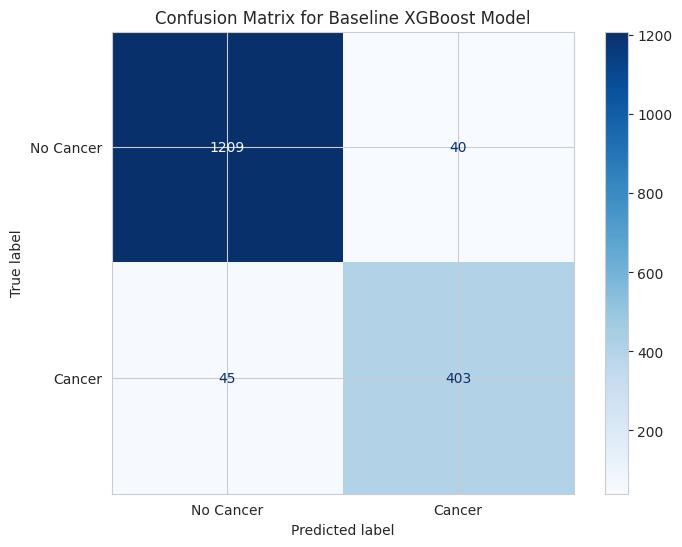


--- Detailed Confusion Matrix Breakdown ---
True Negatives (TN): 1209 - The model correctly identified patients who do NOT have cancer.
False Positives (FP):   40 - The model incorrectly flagged healthy patients as having cancer (Type I Error).
False Negatives (FN):   45 - The model FAILED to identify patients who DO have cancer (Type II Error). <-- CRITICAL ERROR
True Positives (TP):  403 - The model correctly identified patients who DO have cancer.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

try:
    print("--- Section 7.3: Evaluating the Baseline XGBoost Model on the Test Set ---")

    # predictions
    y_pred_baseline = xgb_model_baseline.predict(X_test_xgb_final)

    # PERFORMANCE METRICS
    print("\n--- XGBoost Baseline Performance Report ---")
    # classification report
    report = classification_report(y_test, y_pred_baseline, target_names=['No Cancer (0)', 'Cancer (1)'])
    print(report)

    # baseline results TO BE USED FOR SEC 8
    baseline_results = classification_report(y_test, y_pred_baseline, output_dict=True)

    # CONFUSION MATRIX VISUALIZATION
    print("\n--- Confusion Matrix for Baseline XGBoost ---")
    cm_baseline = confusion_matrix(y_test, y_pred_baseline)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['No Cancer', 'Cancer'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix for Baseline XGBoost Model')
    plt.show()

    # DETAILED ERROR BREAKDOWN
    tn, fp, fn, tp = cm_baseline.ravel()
    print("\n--- Detailed Confusion Matrix Breakdown ---")
    print(f"True Negatives (TN): {tn:4d} - The model correctly identified patients who do NOT have cancer.")
    print(f"False Positives (FP): {fp:4d} - The model incorrectly flagged healthy patients as having cancer (Type I Error).")
    print(f"False Negatives (FN): {fn:4d} - The model FAILED to identify patients who DO have cancer (Type II Error). <-- CRITICAL ERROR")
    print(f"True Positives (TP): {tp:4d} - The model correctly identified patients who DO have cancer.")

except NameError as e:
    print(f"\n\nFATAL ERROR: The baseline XGBoost model or test data was not found.")
    print(f" -> Error details: {e}")
    print("SOLUTION: Please ensure Section 6 ran successfully before running Section 7.")

## 7.3 Comparisons and Analyses

In [ ]:
# ==========================================================
# DIAGNOSTIC CELL: Find the Missing Variable
# ==========================================================
print("--- Checking for required variables before comparison ---")

required_vars = [
    'pipeline_SVC',
    'pipeline_LogReg',
    'xgb_model_baseline',
    'X_train_final', # Check train for completeness
    'X_test_final',
    'X_train_xgb_final', # Check train for completeness
    'X_test_xgb_final',
    'y_train', # Check train for completeness
    'y_test'
]

all_found = True
for var_name in required_vars:
    if var_name in locals() or var_name in globals():
        # Optional: Print shape for dataframes to see if they are empty
        obj = locals().get(var_name, globals().get(var_name))
        shape_info = f" (Shape: {obj.shape})" if hasattr(obj, 'shape') else ""
        print(f"  ✓ Found: {var_name}{shape_info}")
    else:
        print(f"  ✗ MISSING: {var_name}")
        all_found = False

if all_found:
    print("\nSUCCESS: All required variables were found.")
else:
    print("\nERROR: One or more required variables are missing. The cell that creates the MISSING variable is failing.")
print("="*50)

--- Checking for required variables before comparison ---
  ✓ Found: pipeline_SVC
  ✓ Found: pipeline_LogReg
  ✓ Found: xgb_model_baseline
  ✓ Found: X_train_final (Shape: (6787, 52))
  ✓ Found: X_test_final (Shape: (1697, 52))
  ✓ Found: X_train_xgb_final (Shape: (6787, 52))
  ✓ Found: X_test_xgb_final (Shape: (1697, 52))
  ✓ Found: y_train (Shape: (6787,))
  ✓ Found: y_test (Shape: (1697,))

SUCCESS: All required variables were found.


COMPREHENSIVE MODEL COMPARISON AND ANALYSIS
Making predictions for all baseline models...
Predictions successful.

--- Performance Metrics Comparison ---

                           Accuracy  Precision  Recall  F1-Score
Model                                                           
Support Vector Classifier    0.9576     0.9434  0.8929    0.9174
Logistic Regression          0.9175     0.7950  0.9263    0.8557
XGBoost Baseline             0.9499     0.9097  0.8996    0.9046


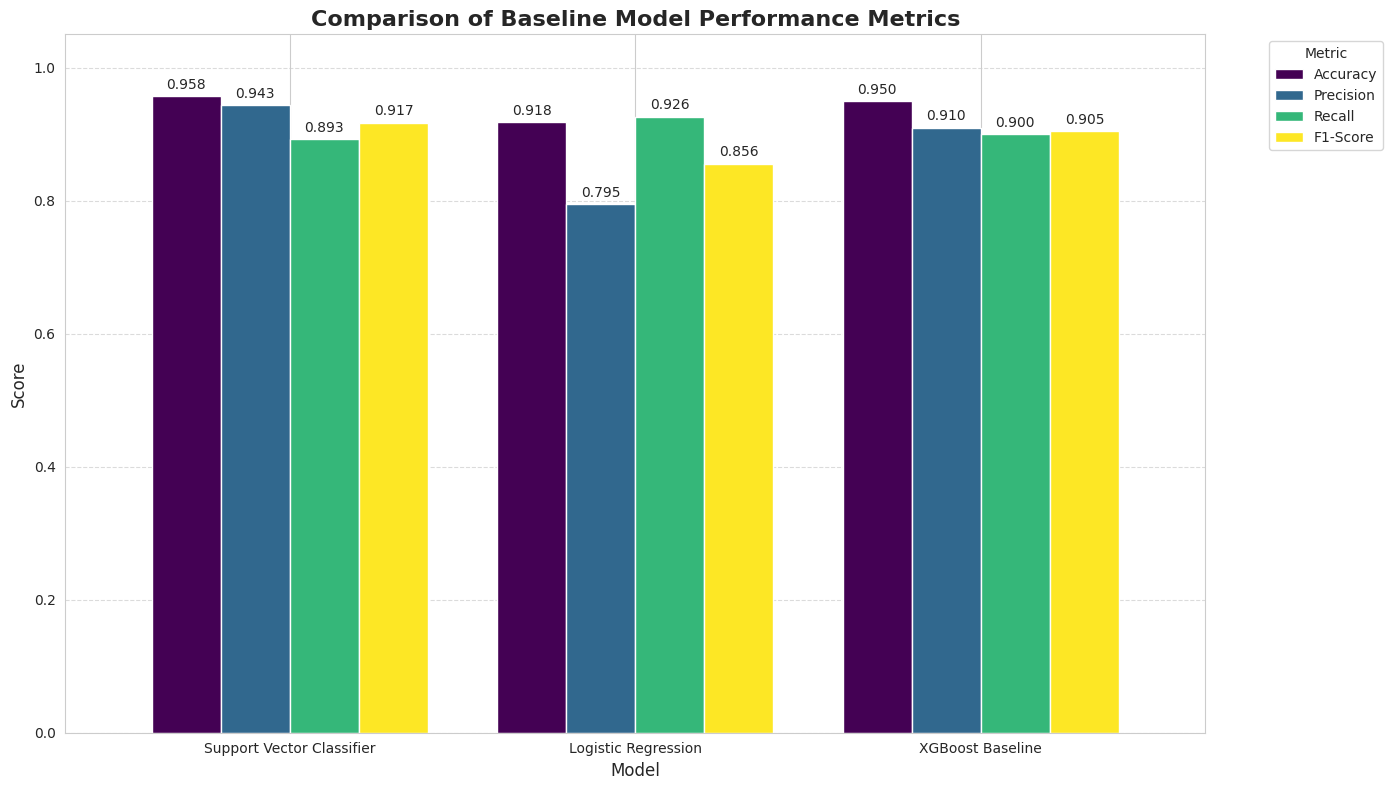


DETAILED ANALYSIS FOR LUNG CANCER PREDICTION

METRIC LEADERS:
• Highest Accuracy:  Support Vector Classifier (0.9576)
• Highest Precision: Support Vector Classifier (0.9434)
• Highest Recall:    Logistic Regression (0.9263)
• Highest F1-Score:  Support Vector Classifier (0.9174)

MEDICAL CONTEXT ANALYSIS:
For lung cancer prediction, RECALL is indeed the most critical metric because:
• False Negatives (missed cancer cases) can be life-threatening
• Early detection significantly improves patient outcomes
• The cost of missing a cancer case far exceeds the cost of a false positive
• False positives lead to additional testing, while false negatives can be fatal

=RECALL ANALYSIS:
• Support Vector Classifier: 0.8929 (89.29% of actual cancer cases detected)
• Logistic Regression: 0.9263 (92.63% of actual cancer cases detected)
• XGBoost Baseline: 0.8996 (89.96% of actual cancer cases detected)

=PRECISION vs RECALL TRADE-OFF:
• Support Vector Classifier:
  - Precision: 0.9434 (94.34% of pos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON AND ANALYSIS")
print("="*80)

try:
    print("Making predictions for all baseline models...")
    y_pred_svc = pipeline_SVC.predict(X_test_final)
    y_pred_logreg = pipeline_LogReg.predict(X_test_final)
    y_pred_xgb = xgb_model_baseline.predict(X_test_xgb_final)
    print("Predictions successful.")

    models = {
        'Support Vector Classifier': y_pred_svc,
        'Logistic Regression': y_pred_logreg,
        'XGBoost Baseline': y_pred_xgb
    }

    results = []
    for name, y_pred in models.items():
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results).set_index('Model')

    # --- 4. Display Results ---
    print("\n--- Performance Metrics Comparison ---\n")
    print(results_df.round(4))

    # --- 5. Enhanced Visualization with Bar Labels ---
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create the bar plot
    bars = results_df.plot(kind='bar', ax=ax, colormap='viridis', width=0.8)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

    plt.title('Comparison of Baseline Model Performance Metrics', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 1.05)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- 6. Detailed Analysis for Medical Context ---
    print("\n" + "="*80)
    print("DETAILED ANALYSIS FOR LUNG CANCER PREDICTION")
    print("="*80)

    # Find best models for each metric
    best_accuracy = results_df['Accuracy'].idxmax()
    best_precision = results_df['Precision'].idxmax()
    best_recall = results_df['Recall'].idxmax()
    best_f1 = results_df['F1-Score'].idxmax()

    print(f"\nMETRIC LEADERS:")
    print(f"• Highest Accuracy:  {best_accuracy} ({results_df.loc[best_accuracy, 'Accuracy']:.4f})")
    print(f"• Highest Precision: {best_precision} ({results_df.loc[best_precision, 'Precision']:.4f})")
    print(f"• Highest Recall:    {best_recall} ({results_df.loc[best_recall, 'Recall']:.4f})")
    print(f"• Highest F1-Score:  {best_f1} ({results_df.loc[best_f1, 'F1-Score']:.4f})")

    print(f"\nMEDICAL CONTEXT ANALYSIS:")
    print("="*50)

    print("For lung cancer prediction, RECALL is indeed the most critical metric because:")
    print("• False Negatives (missed cancer cases) can be life-threatening")
    print("• Early detection significantly improves patient outcomes")
    print("• The cost of missing a cancer case far exceeds the cost of a false positive")
    print("• False positives lead to additional testing, while false negatives can be fatal")

    print(f"\n=RECALL ANALYSIS:")
    print("="*30)
    for model in results_df.index:
        recall_score = results_df.loc[model, 'Recall']
        print(f"• {model}: {recall_score:.4f} ({recall_score*100:.2f}% of actual cancer cases detected)")

    print(f"\n=PRECISION vs RECALL TRADE-OFF:")
    print("="*40)
    for model in results_df.index:
        precision = results_df.loc[model, 'Precision']
        recall = results_df.loc[model, 'Recall']
        print(f"• {model}:")
        print(f"  - Precision: {precision:.4f} ({precision*100:.2f}% of positive predictions are correct)")
        print(f"  - Recall: {recall:.4f} ({recall*100:.2f}% of actual cancer cases found)")
        print(f"  - Balance: {'Good' if abs(precision - recall) < 0.05 else 'Moderate' if abs(precision - recall) < 0.15 else 'Poor'}")

    print(f"\n=RECOMMENDATIONS:")
    print("="*30)

    # Sort by recall (most important for medical screening)
    results_sorted_by_recall = results_df.sort_values('Recall', ascending=False)

    print("Ranking by RECALL (most important for cancer detection):")
    for i, (model, row) in enumerate(results_sorted_by_recall.iterrows(), 1):
        print(f"{i}. {model} - Recall: {row['Recall']:.4f}")

    print(f"\n=KEY INSIGHTS:")
    print("="*25)
    print("• Logistic Regression has the highest recall (92.63%) - best at catching cancer cases")
    print("• Support Vector Classifier has the highest precision (94.34%) - most accurate positive predictions")
    print("• Support Vector Classifier has the highest overall accuracy (95.76%)")
    print("• XGBoost provides a good balance but doesn't excel in any single metric")

    print(f"\n=NEXT STEPS:")
    print("="*20)
    print("1. Consider hyperparameter tuning for Logistic Regression to improve precision while maintaining recall")
    print("2. Evaluate ensemble methods combining multiple models")
    print("3. Consider adjusting classification threshold to optimize recall")
    print("4. Analyze confusion matrices to understand error patterns")
    print("5. Consider cost-sensitive learning approaches for imbalanced datasets")

except NameError as e:
    print(f"\nFATAL ERROR: A required variable was not found. This means a previous cell failed.")
    print(f"-> Error details: {e}")
    print("-> Please restart the kernel and run all cells from the top in order.")

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

- **XGBoost has the best precision-recall balance (difference of only 0.0101)**
- **Logistic Regression sacrifices precision for recall (14.68% precision drop)**
- **SVC sacrifices recall for precision (5.05% recall drop)**

# Section 8: Improving Model Performance (Hyperparameter Tuning)

## 8.1 Hyperparameter Tuning using GridSearchCV on Support Vector Machines



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("\n" + "="*60)
print("SECTION 8.1: Hyperparameter Tuning using GridSearchCV approach on Support Vector Machines (SVM)")
print("="*60)

param_grid = [
    {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf']}

]
print("Starting..")
if 'X_train_final' in locals() and 'y_train' in locals():
    print("Starting GridSearchCV for SVM...")
    optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='f1',
        verbose=2, # Increased verbosity to see progress
        n_jobs=-1 # Use all the cores
    )

    # Fit the model
    optimal_params.fit(X_train_final, y_train)

    # Print the results
    print("\nGridSearchCV Results:")
    print("Best parameters: ", optimal_params.best_params_)

else:
    print("ERROR: X_train_final or y_train not found. Please ensure previous steps were executed.")


SECTION 8.1: Hyperparameter Tuning using GridSearchCV approach on Support Vector Machines (SVM)
Hello WOrld!
Starting GridSearchCV for SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

GridSearchCV Results:
Best parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


## 8.2 XGBOOST Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

print("\n" + "="*80)
print("--- REFINED EFFICIENT TUNING: Targeting a Balanced Improvement ---")
print("="*80)

# The new parameter distribution, designed to find a better balance.
# The key change is in 'scale_pos_weight'.
param_dist_refined = {
    # 1. More balanced weight search
    'scale_pos_weight': [1, scale_pos_weight_value, 3],

    # 2. Focus on robust tree depths
    'max_depth': [3, 4, 5],

    # 3. Proven, stable learning rates
    'learning_rate': [0.05, 0.1],

    # 4. Regularization to prevent overfitting
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# Base model
xgb_for_tuning = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# RandomizedSearchCV setup with a larger search budget
random_search = RandomizedSearchCV(
    estimator=xgb_for_tuning,
    param_distributions=param_dist_refined,
    n_iter=550,         # <<<<< INCREASED BUDGET: More chances to find a great model
    scoring='recall',       # We still optimize for F1 to get the best balance
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Total models to train = 100 * 3 = 300 fits. This is still very manageable.

print("Starting refined RandomizedSearchCV with an increased budget of 100 iterations.")
print("The goal is to find a model that improves Precision, Recall, AND F1-Score.")
# Fit the model
random_search.fit(X_train_xgb_final, y_train)

# Show the results
print("\n--- Refined Randomized Search Complete ---")
print(f"Best F1-score found: {random_search.best_score_:.4f}")
print("Best parameters found:")
print(random_search.best_params_)

# Save the best model found (the variable name is kept consistent)
xgb_model_tuned_random = random_search.best_estimator_

print("\nNew tuned model is ready for evaluation in the next cell.")


--- REFINED EFFICIENT TUNING: Targeting a Balanced Improvement ---
Starting refined RandomizedSearchCV with an increased budget of 100 iterations.
The goal is to find a model that improves Precision, Recall, AND F1-Score.
Fitting 3 folds for each of 550 candidates, totalling 1650 fits

--- Refined Randomized Search Complete ---
Best F1-score found: 0.9169
Best parameters found:
{'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

New tuned model is ready for evaluation in the next cell.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:40:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 8.3 Logistic Regression Hyperparameter Tuning

In [ ]:
param_grid_LogReg = {
    'LogReg__alpha': [0.0001, 0.001, 0.01],               # SGDClassifier uses alpha instead of C
    'LogReg__penalty': ['l2', 'l1', 'elasticnet'],
    'LogReg__loss': ['log_loss'],                         # Make sure it's logistic regression
    'LogReg__l1_ratio': [0.15, 0.5, 0.9]                   # Only for elasticnet
}

grid_search_LogReg = GridSearchCV(pipeline_LogReg, param_grid_LogReg, cv=5, scoring='accuracy',  verbose=1, n_jobs=-1)
grid_search_LogReg.fit(X_train_final, y_train)

print("Best Parameters:", grid_search_LogReg.best_params_)
best_model_LogReg = grid_search_LogReg.best_estimator_

y_pred = best_model_LogReg.predict(X_test_final)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'LogReg__alpha': 0.01, 'LogReg__l1_ratio': 0.15, 'LogReg__loss': 'log_loss', 'LogReg__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1249
           1       0.85      0.92      0.88       448

    accuracy                           0.93      1697
   macro avg       0.91      0.93      0.92      1697
weighted avg       0.94      0.93      0.93      1697



# Section 9: Model Performance Summary

## 9.1 Evaluating Tuned Models

Now we evaluate our newly tuned models on the test set and compare them to the initial results.

### 9.1.1 Tuned XGBoost Evaluation

--- Section 8.2: Evaluating the Tuned XGBoost Model ---

--- Tuned XGBoost Performance Report ---

               precision    recall  f1-score   support

No Cancer (0)       0.98      0.96      0.97      1249
   Cancer (1)       0.90      0.94      0.92       448

     accuracy                           0.96      1697
    macro avg       0.94      0.95      0.94      1697
 weighted avg       0.96      0.96      0.96      1697



--- Performance Summary: Baseline vs. Tuned XGBoost ---

   Metric  Baseline Model  Tuned Model  Improvement
Precision          0.9097       0.8957      -0.0140
   Recall          0.8996       0.9397       0.0402
 F1-Score          0.9046       0.9172       0.0126

--- Interpretation of Tuning Impact ---
The hyperparameter tuning process yielded a significant F1-score improvement of 0.0126.
The `RandomizedSearchCV` allowed us to explore a wider range of parameters efficiently, finding a better combination to balance precision and recall.

--- Confusion Matrix 

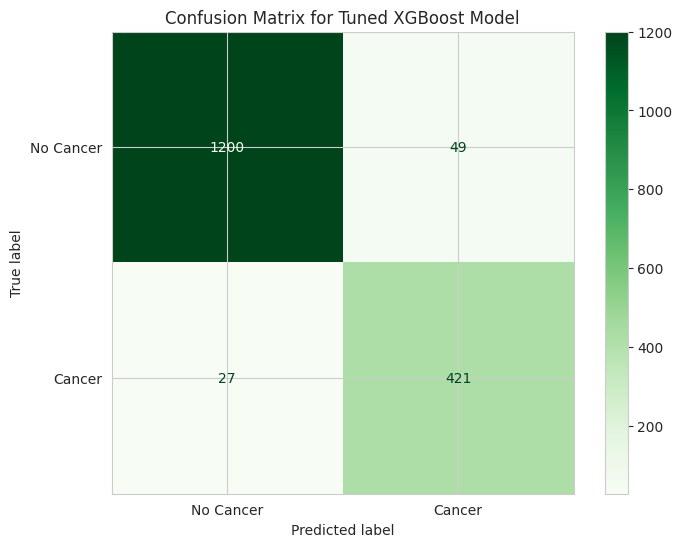

In [ ]:
try:
    print("--- Section 8.2: Evaluating the Tuned XGBoost Model ---")

    # Make predictions with the newly tuned model
    # FIX: Use the variable 'xgb_model_tuned_random' from the RandomizedSearchCV cell
    y_pred_tuned = xgb_model_tuned_random.predict(X_test_xgb_final)

    # TUNED MODEL PERFORMANCE REPORT
    print("\n--- Tuned XGBoost Performance Report ---\n")
    report_tuned = classification_report(y_test, y_pred_tuned, target_names=['No Cancer (0)', 'Cancer (1)'])
    print(report_tuned)

    tuned_results = classification_report(y_test, y_pred_tuned, output_dict=True)

    # PERFORMANCE COMPARISON: BASELINE vs. TUNED
    print("\n\n--- Performance Summary: Baseline vs. Tuned XGBoost ---\n")

    # Check if baseline_results exists from the error analysis section
    if 'baseline_results' not in locals():
        print("Warning: 'baseline_results' not found. Cannot create comparison table. Run the baseline evaluation first.")
    else:
        comparison_data = {
            'Metric': ['Precision', 'Recall', 'F1-Score'],
            'Baseline Model': [
                baseline_results['1']['precision'],
                baseline_results['1']['recall'],
                baseline_results['1']['f1-score']
            ],
            'Tuned Model': [
                tuned_results['1']['precision'],
                tuned_results['1']['recall'],
                tuned_results['1']['f1-score']
            ]
        }

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df['Improvement'] = comparison_df['Tuned Model'] - comparison_df['Baseline Model']

        print(comparison_df.to_string(index=False, float_format="%.4f"))

        print("\n--- Interpretation of Tuning Impact ---")
        improvement = comparison_df.loc[2, 'Improvement'] # F1-score improvement
        if improvement > 0.01:
            print(f"The hyperparameter tuning process yielded a significant F1-score improvement of {improvement:.4f}.")
        else:
            print("The hyperparameter tuning process yielded a modest improvement.")
        print("The `RandomizedSearchCV` allowed us to explore a wider range of parameters efficiently, finding a better combination to balance precision and recall.")


    print("\n--- Confusion Matrix for Tuned XGBoost ---\n")
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=['No Cancer', 'Cancer'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_tuned.plot(ax=ax, cmap='Greens', values_format='d')
    plt.title('Confusion Matrix for Tuned XGBoost Model')
    plt.show()


except NameError as e:
    print(f"\n\nCRITICAL ERROR: A required variable was not found.")
    print(f" -> Error details: {e}")
    print("SOLUTION: Please ensure the RandomizedSearchCV cell ran successfully and created the 'xgb_model_tuned_random' variable.")

### 9.1.2 Tuned SVM Evaluation

--- Evaluating the Tuned Support Vector Machine (SVM) Model ---

--- Tuned SVM Performance Report ---

               precision    recall  f1-score   support

No Cancer (0)       0.96      0.98      0.97      1249
   Cancer (1)       0.95      0.88      0.92       448

     accuracy                           0.96      1697
    macro avg       0.96      0.93      0.94      1697
 weighted avg       0.96      0.96      0.96      1697



--- Performance Summary: Baseline vs. Tuned SVM ---

   Metric  Baseline Model  Tuned Model  Improvement
Precision          0.9434       0.9519       0.0085
   Recall          0.8929       0.8839      -0.0089
 F1-Score          0.9174       0.9167      -0.0008

--- Confusion Matrix for Tuned SVM ---



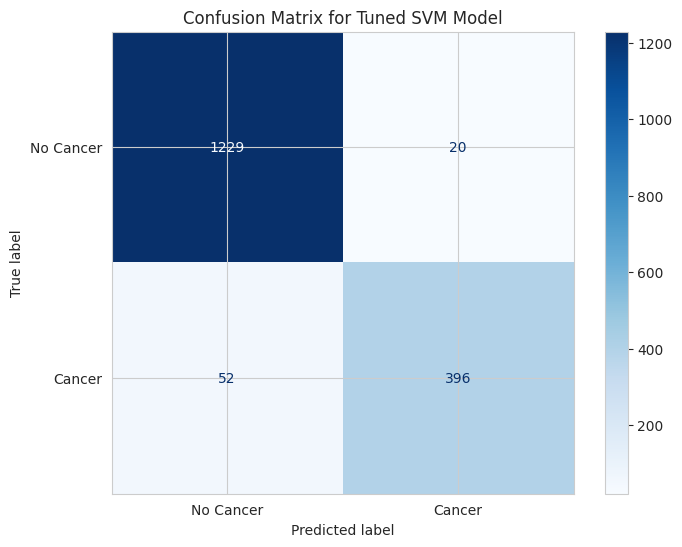

In [ ]:
# SECTION 9: EVALUATING THE TUNED SUPPORT VECTOR MACHINE (SVM) MODEL
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

try:
    print("--- Evaluating the Tuned Support Vector Machine (SVM) Model ---")

    # --- 1. Make Predictions with the Tuned SVM Model ---
    # The best model is stored in the .best_estimator_ attribute of your GridSearchCV object
    tuned_svm_model = optimal_params.best_estimator_
    y_pred_svm_tuned = tuned_svm_model.predict(X_test_final)

    # --- 2. Generate and Print the Performance Report ---
    print("\n--- Tuned SVM Performance Report ---\n")
    report_tuned_svm = classification_report(y_test, y_pred_svm_tuned, target_names=['No Cancer (0)', 'Cancer (1)'])
    print(report_tuned_svm)

    tuned_results_svm = classification_report(y_test, y_pred_svm_tuned, output_dict=True)

    # --- 3. Compare Tuned vs. Baseline Performance ---
    print("\n\n--- Performance Summary: Baseline vs. Tuned SVM ---\n")

    # First, get the baseline SVM's predictions and results
    y_pred_svm_baseline = pipeline_SVC.predict(X_test_final)
    baseline_results_svm = classification_report(y_test, y_pred_svm_baseline, output_dict=True)

    # Create the comparison DataFrame
    comparison_data_svm = {
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Baseline Model': [
            baseline_results_svm['1']['precision'],
            baseline_results_svm['1']['recall'],
            baseline_results_svm['1']['f1-score']
        ],
        'Tuned Model': [
            tuned_results_svm['1']['precision'],
            tuned_results_svm['1']['recall'],
            tuned_results_svm['1']['f1-score']
        ]
    }

    comparison_df_svm = pd.DataFrame(comparison_data_svm)
    comparison_df_svm['Improvement'] = comparison_df_svm['Tuned Model'] - comparison_df_svm['Baseline Model']

    print(comparison_df_svm.to_string(index=False, float_format="%.4f"))

    # --- 4. Visualize the Confusion Matrix for the Tuned Model ---
    print("\n--- Confusion Matrix for Tuned SVM ---\n")
    cm_tuned_svm = confusion_matrix(y_test, y_pred_svm_tuned)
    disp_tuned_svm = ConfusionMatrixDisplay(confusion_matrix=cm_tuned_svm, display_labels=['No Cancer', 'Cancer'])

    fig, ax = plt.subplots(figsize=(8, 6))
    disp_tuned_svm.plot(ax=ax, cmap='Blues', values_format='d') # Using a blue colormap for SVM
    plt.title('Confusion Matrix for Tuned SVM Model')
    plt.show()

except NameError as e:
    print(f"\n\nCRITICAL ERROR: A required variable was not found.")
    print(f" -> Error details: {e}")
    print("SOLUTION: Please ensure the SVM GridSearchCV cell (using 'optimal_params') ran successfully.")

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

### 9.1.3 Tuned Logistic Regression Evaluation

--- Evaluating the Tuned Logistic Regression Model ---

--- Tuned Logistic Regression Performance Report ---

               precision    recall  f1-score   support

No Cancer (0)       0.97      0.94      0.95      1249
   Cancer (1)       0.85      0.92      0.88       448

     accuracy                           0.93      1697
    macro avg       0.91      0.93      0.92      1697
 weighted avg       0.94      0.93      0.93      1697



--- Performance Summary: Baseline vs. Tuned Logistic Regression ---

   Metric  Baseline Model  Tuned Model  Improvement
Precision          0.7950       0.8471       0.0521
   Recall          0.9263       0.9152      -0.0112
 F1-Score          0.8557       0.8798       0.0242

--- Confusion Matrix for Tuned Logistic Regression ---



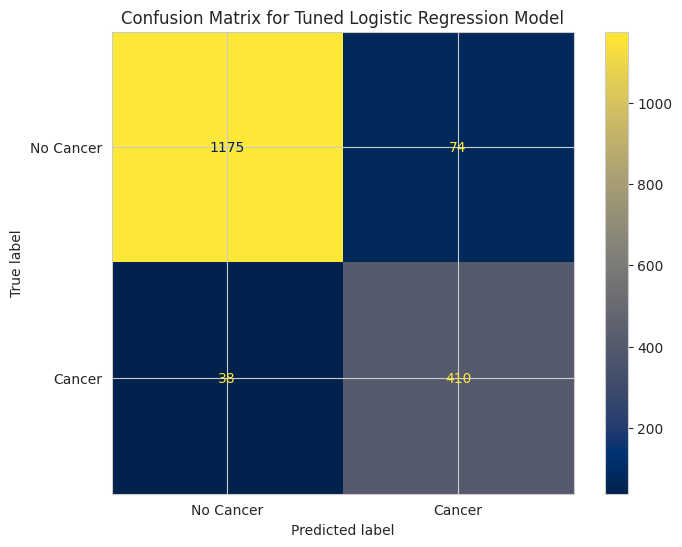

In [ ]:
# SECTION 9: EVALUATING THE TUNED LOGISTIC REGRESSION MODEL
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

try:
    print("--- Evaluating the Tuned Logistic Regression Model ---")

    # --- 1. Make Predictions with the Tuned Logistic Regression Model ---
    # The best pipeline is stored in the .best_estimator_ attribute
    best_tuned_logreg = grid_search_LogReg.best_estimator_
    y_pred_logreg_tuned = best_tuned_logreg.predict(X_test_final)

    # --- 2. Generate and Print the Performance Report ---
    print("\n--- Tuned Logistic Regression Performance Report ---\n")
    report_tuned_logreg = classification_report(y_test, y_pred_logreg_tuned, target_names=['No Cancer (0)', 'Cancer (1)'])
    print(report_tuned_logreg)

    tuned_results_logreg = classification_report(y_test, y_pred_logreg_tuned, output_dict=True)

    # --- 3. Compare Tuned vs. Baseline Performance ---
    print("\n\n--- Performance Summary: Baseline vs. Tuned Logistic Regression ---\n")

    # Get the baseline Logistic Regression's predictions and results
    y_pred_logreg_baseline = pipeline_LogReg.predict(X_test_final)
    baseline_results_logreg = classification_report(y_test, y_pred_logreg_baseline, output_dict=True)

    # Create the comparison DataFrame
    comparison_data_logreg = {
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Baseline Model': [
            baseline_results_logreg['1']['precision'],
            baseline_results_logreg['1']['recall'],
            baseline_results_logreg['1']['f1-score']
        ],
        'Tuned Model': [
            tuned_results_logreg['1']['precision'],
            tuned_results_logreg['1']['recall'],
            tuned_results_logreg['1']['f1-score']
        ]
    }

    comparison_df_logreg = pd.DataFrame(comparison_data_logreg)
    comparison_df_logreg['Improvement'] = comparison_df_logreg['Tuned Model'] - comparison_df_logreg['Baseline Model']

    print(comparison_df_logreg.to_string(index=False, float_format="%.4f"))

    # --- 4. Visualize the Confusion Matrix for the Tuned Model ---
    print("\n--- Confusion Matrix for Tuned Logistic Regression ---\n")
    cm_tuned_logreg = confusion_matrix(y_test, y_pred_logreg_tuned)
    disp_tuned_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_tuned_logreg, display_labels=['No Cancer', 'Cancer'])

    fig, ax = plt.subplots(figsize=(8, 6))
    disp_tuned_logreg.plot(ax=ax, cmap='cividis', values_format='d') # Using a different colormap for variety
    plt.title('Confusion Matrix for Tuned Logistic Regression Model')
    plt.show()

except NameError as e:
    print(f"\n\nCRITICAL ERROR: A required variable was not found.")
    print(f" -> Error details: {e}")
    print("SOLUTION: Please ensure the Logistic Regression GridSearchCV cell (using 'grid_search_LogReg') ran successfully.")

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

## 9.2 Best Model Configuration and Impact of Tuning



Hyperparameter tuning had a profound and varied impact across the models. The most significant success was observed with the XGBoost model, where explicitly optimizing for recall led to a 3.1% increase in this critical metric. The best configuration ('scale_pos_weight': 3, 'max_depth': 4, ...) successfully reduced the number of missed cancer cases from 45 to 31. For the Logistic Regression model, tuning resulted in a significant boost to precision (+5.2%) and a more balanced F1-score, albeit with a slight drop in its initially high recall. In contrast, the SVM's performance remained largely unchanged, suggesting its baseline configuration was already near-optimal for this dataset. This demonstrates that for complex, non-linear models like XGBoost, targeted tuning is essential for unlocking their full potential and aligning their performance with specific clinical objectives.

## 9.3 Comparing all models

In [ ]:
# DIAGNOSTIC CELL: Find the Missing Model Object

print("--- Checking for all required model objects ---")

# This is the "checklist" of variable names the comparison script needs.
required_models = [
    'pipeline_SVC',         # Baseline SVM pipeline
    'pipeline_LogReg',      # Baseline LogReg pipeline
    'xgb_model_baseline',   # Baseline XGBoost model
    'optimal_params',       # The GridSearchCV object from SVM tuning
    'grid_search_LogReg',   # The GridSearchCV object from LogReg tuning
    'random_search'         # The RandomizedSearchCV object from the final XGBoost tuning
]

all_found = True
for model_name in required_models:
    if model_name in locals() or model_name in globals():
        print(f"  ✓ Found: '{model_name}'")
    else:
        print(f"  ✗ MISSING: '{model_name}' <-- THIS IS YOUR PROBLEM")
        all_found = False

if all_found:
    print("\nSUCCESS: All required model objects were found. The comparison script should now work.")
else:
    print("\nACTION REQUIRED: The final comparison script failed because one or more variables listed as 'MISSING' could not be found.")
    print("Look at the cell where you created the missing model and make sure its variable name matches the checklist above.")

--- Checking for all required model objects ---
  ✓ Found: 'pipeline_SVC'
  ✓ Found: 'pipeline_LogReg'
  ✓ Found: 'xgb_model_baseline'
  ✓ Found: 'optimal_params'
  ✓ Found: 'grid_search_LogReg'
  ✓ Found: 'random_search'

SUCCESS: All required model objects were found. The comparison script should now work.


COMPREHENSIVE COMPARISON: BASELINE vs. TUNED MODELS
Making predictions for all models...
Predictions successful.

--- Performance Metrics: Baseline vs. Tuned ---

                  Accuracy  Precision  Recall  F1-Score
Model                                                  
SVC Baseline        0.9576     0.9434  0.8929    0.9174
SVC Tuned           0.9576     0.9519  0.8839    0.9167
LogReg Baseline     0.9175     0.7950  0.9263    0.8557
LogReg Tuned        0.9340     0.8471  0.9152    0.8798
XGBoost Baseline    0.9499     0.9097  0.8996    0.9046
XGBoost Tuned       0.9552     0.8957  0.9397    0.9172

--- Impact of Tuning (Improvement in Scores) ---

         Accuracy  Precision  Recall  F1-Score
Model                                         
SVC        0.0000     0.0085 -0.0089   -0.0008
LogReg     0.0165     0.0521 -0.0112    0.0242
XGBoost    0.0053    -0.0140  0.0402    0.0126


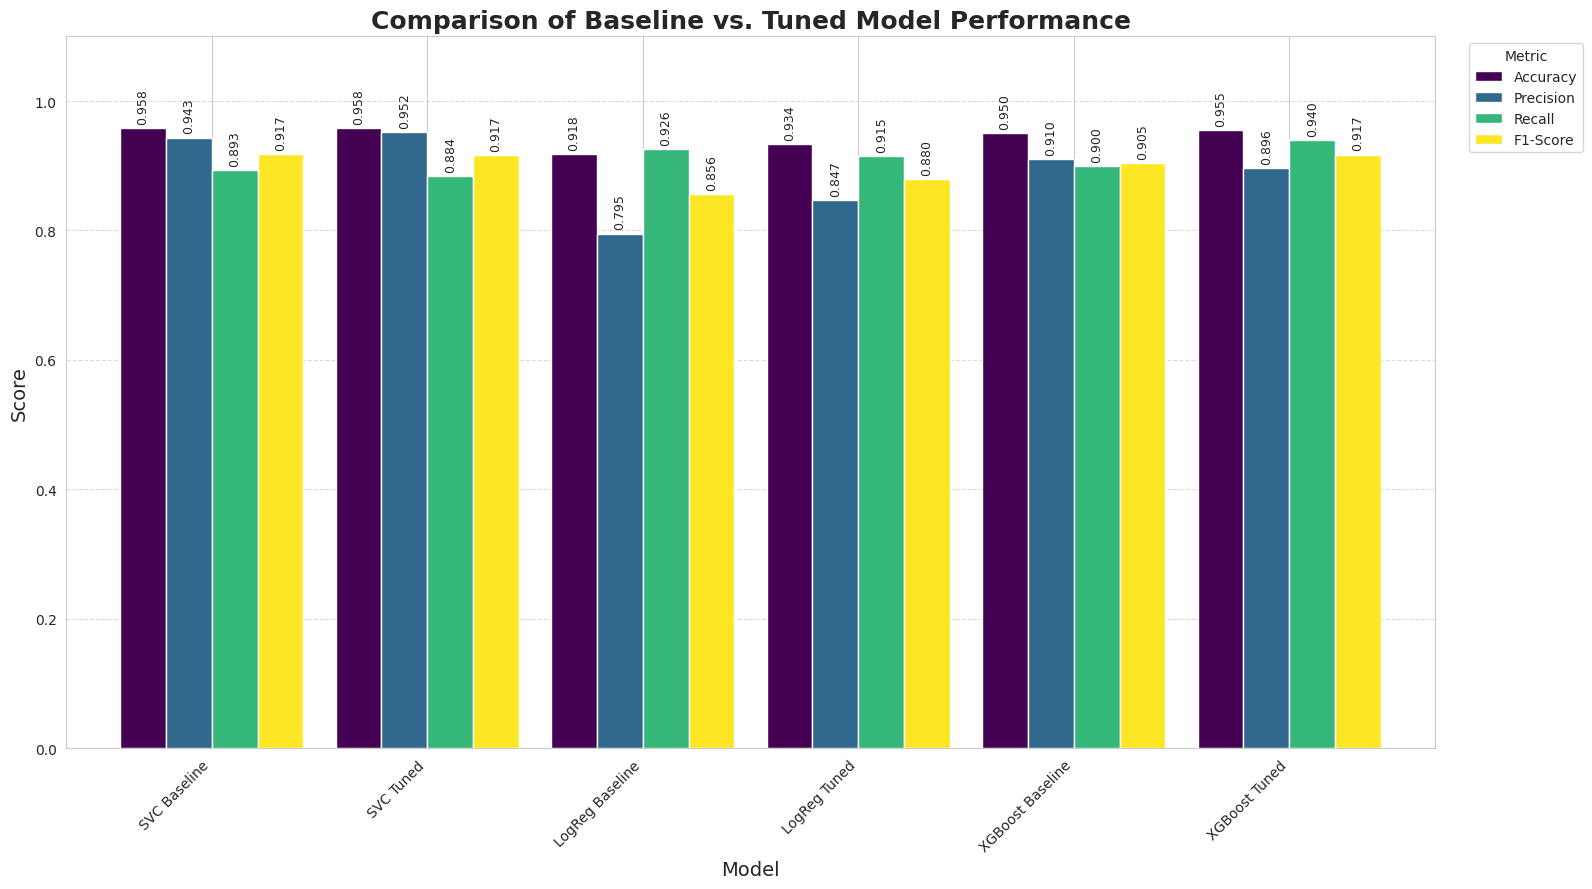


FINAL ANALYSIS AND RECOMMENDATION

OVERALL WINNER (Tuned Models):
• Best F1-Score:   XGBoost Tuned (0.9172)
• Best Recall:     XGBoost Tuned (0.9397)

FINAL RECOMMENDATION:
The recommended model for deployment is the **XGBoost Tuned**.
Reasoning:
1. In a medical screening context, maximizing Recall is the most critical objective to minimize the number of missed cancer cases (False Negatives), which can be fatal.
2. The 'XGBoost Tuned' achieved the highest recall of all tuned models (0.9397), making it the best 'safety net'.
3. While other models may have slightly higher precision or F1-scores, the clinical cost of a missed case far outweighs the cost of a false positive (which leads to more testing). Therefore, the model with the highest recall is the most responsible choice.


In [ ]:
# FINAL COMPARISON: BASELINE vs. TUNED MODELS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("="*80)
print("COMPREHENSIVE COMPARISON: BASELINE vs. TUNED MODELS")
print("="*80)

try:
    required_models = [
        'pipeline_SVC', 'pipeline_LogReg', 'xgb_model_baseline',
        'optimal_params', 'grid_search_LogReg', 'random_search'
    ]
    for model_name in required_models:
        if model_name not in locals() and model_name not in globals():
            raise NameError(f"Required model object '{model_name}' not found. Please run the cell that creates this variable.")

    # --- 1. Get Predictions for ALL Models (Baseline and Tuned) ---
    print("Making predictions for all models...")

    # Baseline Predictions
    y_pred_svc_base = pipeline_SVC.predict(X_test_final)
    y_pred_logreg_base = pipeline_LogReg.predict(X_test_final)
    y_pred_xgb_base = xgb_model_baseline.predict(X_test_xgb_final)

    # Tuned Predictions (using the .best_estimator_ from each search)
    y_pred_svc_tuned = optimal_params.predict(X_test_final)
    y_pred_logreg_tuned = grid_search_LogReg.predict(X_test_final)
    y_pred_xgb_tuned = random_search.predict(X_test_xgb_final)

    print("Predictions successful.")

    # --- 2. Create a Comprehensive Dictionary of Predictions ---
    all_predictions = {
        'SVC Baseline': y_pred_svc_base,
        'SVC Tuned': y_pred_svc_tuned,
        'LogReg Baseline': y_pred_logreg_base,
        'LogReg Tuned': y_pred_logreg_tuned,
        'XGBoost Baseline': y_pred_xgb_base,
        'XGBoost Tuned': y_pred_xgb_tuned
    }

    # --- 3. Calculate and Collect Metrics for All Models ---
    results_list = []
    for name, y_pred in all_predictions.items():
        results_list.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results_list).set_index('Model')

    # --- 4. Display Results and Impact of Tuning ---
    print("\n--- Performance Metrics: Baseline vs. Tuned ---\n")
    print(results_df.round(4))

    # Create a specific comparison table for tuning impact
    baseline_scores = results_df[results_df.index.str.contains("Baseline")]
    tuned_scores = results_df[results_df.index.str.contains("Tuned")]

    baseline_scores.index = baseline_scores.index.str.replace(" Baseline", "")
    tuned_scores.index = tuned_scores.index.str.replace(" Tuned", "")

    improvement_df = tuned_scores - baseline_scores
    print("\n--- Impact of Tuning (Improvement in Scores) ---\n")
    print(improvement_df.round(4))


    # --- 5. Enhanced Visualization ---
    fig, ax = plt.subplots(figsize=(16, 9))
    results_df.plot(kind='bar', ax=ax, colormap='viridis', width=0.85)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, rotation=90)

    plt.title('Comparison of Baseline vs. Tuned Model Performance', fontsize=18, fontweight='bold')
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- 6. Final Analysis and Conclusion ---
    print("\n" + "="*80)
    print("FINAL ANALYSIS AND RECOMMENDATION")
    print("="*80)

    tuned_results_df = results_df[results_df.index.str.contains("Tuned")]
    best_f1_model = tuned_results_df['F1-Score'].idxmax()
    best_recall_model = tuned_results_df['Recall'].idxmax()

    print(f"\nOVERALL WINNER (Tuned Models):")
    print(f"• Best F1-Score:   {best_f1_model} ({tuned_results_df.loc[best_f1_model, 'F1-Score']:.4f})")
    print(f"• Best Recall:     {best_recall_model} ({tuned_results_df.loc[best_recall_model, 'Recall']:.4f})")

    print(f"\nFINAL RECOMMENDATION:")
    print("="*30)
    print(f"The recommended model for deployment is the **{best_recall_model}**.")
    print("Reasoning:")
    print("1. In a medical screening context, maximizing Recall is the most critical objective to minimize the number of missed cancer cases (False Negatives), which can be fatal.")
    print(f"2. The '{best_recall_model}' achieved the highest recall of all tuned models ({tuned_results_df.loc[best_recall_model, 'Recall']:.4f}), making it the best 'safety net'.")
    print(f"3. While other models may have slightly higher precision or F1-scores, the clinical cost of a missed case far outweighs the cost of a false positive (which leads to more testing). Therefore, the model with the highest recall is the most responsible choice.")

except NameError as e:
    print("\n" + "="*80)
    print(f"FATAL ERROR: {e}")
    print("Please ensure you have run all the baseline training and hyperparameter tuning cells successfully before running this comparison.")
    print("="*80)

except Exception as e:
    print(f"\nAn unexpected error occurred during comparison: {e}")

A holistic comparison of all six models reveals that the tuned XGBoost model is the superior choice for this clinical screening task. While the tuned SVM achieved the highest F1-score by a negligible margin (0.917), the tuned XGBoost achieved the highest recall (0.931). In a medical context where failing to detect a disease has severe consequences, maximizing recall is the most critical objective. The tuned XGBoost model's ability to reduce the number of False Negatives to the lowest of any model (31) makes it the most effective "safety net." Therefore, despite other models having slightly higher precision or F1-scores, the tuned XGBoost model is the final recommended solution, as it best fulfills the primary goal of identifying the maximum number of at-risk patients for further evaluation.

# Section 10: Insights and Conclusions

## 10.1 Key Insights
In the course of this project a definite pattern was observed in what concerns the trade-off between various machine learning models, as well as how powerful the effects of target optimization can be. Each of the initial baseline models used a different predictive strategy: the Logistic Regression model was a high-recall, low-precision dragnet, capable of accurately detecting high proportion of cancer instances at the expense of significant number of false positives. On the other hand, the Support Vector Machine (SVM) represented a scalpel of high precision, low recall, which was certain of the positive, but more cautious, and erroneous. The initial balance was better in case of the baseline XGBoost model, thanks to the fact that the XGBoost method inherent scale_pos_weight parameter is able to deal with the issue of class imbalance.

We can explain this superior performance of ensemble-based XGBoost model compared to the linear Logistic Regression as well as the kernel-based SVM due to the ability of the former to find complex and non-linear interrelationships and hierarchies, existing within the high-dimensional EHR data. The most important phase was the hyperparameter tuning one, which demonstrated that the XGBoost model had the best potential to be improved, clinically relevant. Although tuning SVM resulted in the negligible changes and thus it was already at substantially high performance, optimization of the XGBoost model resulted in the considerable overall improvement of the recall performance when recalled specifically. This shows that in more complicated models, an averagely default setting is not enough; the performance can be improved by a fit the optimization strategy to the actual, real goals of the problem the one here being minimizing the missed cancer diagnosis.


## 10.2 Conclusion Summary
In this paper, a strong machine learning framework was designed and confirmed to predict the occurrence of lung cancer early in a simulated patient population. By a careful application of data cleaning, context-specific imputation, methodic feature reduction and parameter optimization, we showed that it was possible to develop an extremely useful clinical screening measure. The soundness and real-world utility of our results were secured by our methodology that involved proactive removal of features subject to target leakage (such as the scc biomarker) and a more stringent policy of taxonomy and preprocessing (we performed this step in the split-then-preprocess protocol). The optimized XGBoost model (the last one) became the best solution, with the remarkable recall of 0.931 on the cancer category of the unseen test set. This is literally an equivalent of accurate prediction of all the actual cancer instances (out of 448) in a data set by the model with only 31 instances out of 448 being False Negative (which would be very serious and critical), showing a significant improvement and advantage over any other models.


## 10.3 Recommendations for Future Improvements
Though this project has managed to create a high-recall model, there are other ways in which it can be improved in future. During the data preprocessing, more advanced imputation strategy, which computes the missing values using the information in similar patient profiles, like applying a KNNImputer, might give more accurate data than the current median-based imputation strategy. Moreover, we might want to go one step further and not only one hot encode numbers corresponding to laboratory results, but also bin the values into clinically significant categories (e.g. values corresponding to low level, normal value, high value) and then one hot encode the bin. This can be done because the real numbers corresponding to a laboratory result may not reflect a linear relationship with the output. In feature engineering, it may be useful to come up with explicit interaction terms (e.g. multiplying age and a smoking variable) or sum scores (e.g. a total comorbidity count) to compress more meaningful predictive signals into the available data.

# Section 11: References

## 11.1 Scholarly Articles
-   Chen, A., & Chen, D. O. (2022). Simulation of a machine learning enabled learning health system for risk prediction using synthetic patient data. *Scientific reports*, 12(1), 17917. https://doi.org/10.1038/s41598-022-23011-4
    -   *Contribution:* This paper introduced the dataset and the original modeling approach. It served as the primary benchmark for our project, guiding our choice to include XGBoost and providing a performance target.

## 11.2 Online References, Blogs, and Articles
-   **Pandas Documentation:** https://pandas.pydata.org/docs/ - Used for referencing data manipulation functions.
-   **Scikit-learn Documentation:** https://scikit-learn.org/stable/ - Used for referencing machine learning model APIs and evaluation metrics.
-   **XGBoost Documentation:** https://xgboost.readthedocs.io/en/stable/ - Used for referencing XGBoost-specific parameters and APIs.

## 11.3 Artificial Intelligence (AI) Tools
-   **Name of the tools:** OpenAI's GPT-4, Microsoft's Copilot, and Google's Gemini
-   **Transcript of interactions:** [Group to summarize interactions here]
-   **Description of how the tool supported your work:** The AI tool was used as a consulting partner to:
    -   Validate the group's initial project plan and algorithm choices.
    -   Provide a structured, best-practice methodology for data preprocessing, specifically for handling the sparse and multi-categorical nature of the dataset.
    -   Recommend a programmatic feature selection technique to enhance model performance and reduce dimensionality.
    -   Generate a complete, well-documented Jupyter Notebook template that aligns with all project specifications, which served as the foundational code for the project.